# ACCIDENTES DE TRÁFICO - FORECASTING

Importamos los paquetes que vamos a necesitar:

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

In [3]:
%%capture
pip install pmdarima

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
import itertools

In [5]:
%%capture
pip install fbprophet

In [6]:
import fbprophet
print('Prophet %s' % fbprophet.__version__)
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

Prophet 0.7.1


In [7]:
%%capture
!pip install tensorflow

In [8]:
from keras.models import Sequential
from keras.models import Model

from keras.layers import Dense,Activation,Flatten
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D

from sklearn.preprocessing import MinMaxScaler

from keras.callbacks import Callback

from keras.optimizers import Adam

2022-06-16 22:42:19.603584: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-16 22:42:19.603617: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
path_acc = '/home/dsc/Master DS/TFM/GIT/DATOS_PROCESADOS/accidentes.csv'
accidents = pd.read_csv(path_acc, sep = '^' )

Generamos un dataframe de recuentos de accidentes, donde el índice sea la fecha del recuento con formato 'datetime'.

In [10]:
ser_temp_df = accidents [['fecha','fecha_datetime','ano_fecha','dia_sem','dia_sem_code','mes','es_finde','es_fest']]

In [11]:
num_siniestros = accidents.groupby('fecha_datetime').count().reset_index()

In [12]:
num_siniestros = num_siniestros.rename(columns={'fecha':'num_claims'})

In [13]:
num_siniestros_df = num_siniestros[['fecha_datetime','num_claims']]

In [14]:
ser_temp_df.drop_duplicates(inplace=True)

In [15]:
accidents = num_siniestros_df.merge (ser_temp_df) 

In [16]:
var_drop=['fecha']

In [17]:
accidents.drop(var_drop, inplace=True, axis=1)

In [18]:
num_sin_año = accidents [['fecha_datetime', 'num_claims']]

In [19]:
num_sin_año['datetime'] = pd.to_datetime(num_sin_año['fecha_datetime'], format='%Y-%m-%d')

In [20]:
num_sin_año.drop('fecha_datetime', inplace=True, axis=1)

In [21]:
num_sin_año.set_index('datetime', inplace = True)

Todo los modelos predictivos que vamos a probar van a considerar todo el periodo de muestra como train a excepcion del ultimo mes de diciembre 2021, que serán nuestros datos de test.

In [22]:
train_graf = num_sin_año.loc['2019-01-01': '2021-11-30']
test_graf = num_sin_año.loc['2021-12-01': '2021-12-31']

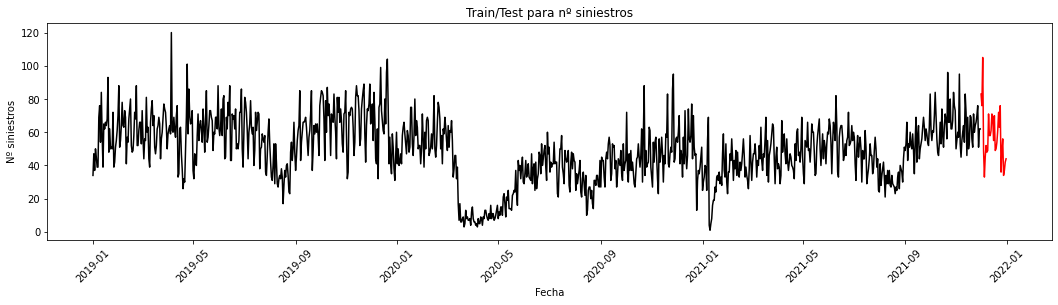

In [23]:
fig,ax = plt.subplots(1,1,figsize=(18,4))
plt.plot(train_graf, color = "black")
plt.plot(test_graf, color = "red")
plt.ylabel('Nº siniestros')
plt.xlabel('Fecha')
plt.xticks(rotation=45)
plt.title("Train/Test para nº siniestros")
plt.show()

Los modelos que vamos a aplicar son los siguientes:

- Modelo estadístico tradicional con componente estacional -- SARIMA
- Modelo estadístico Bayesiano -- PROPHET
- Deep learning -- Red neuronal

## A. SARIMA

Un modelo SARIMA tiene los siguientes componentes:

- **AR(p) Autoregresión** 
    - Un modelo de regresión que utiliza la relación dependiente entre una observación actual y las observaciones durante un período anterior
    - El número de rezagos de Y que se utilizarán como predictores

- **I(d) Integración** 
    - Utiliza la diferenciación de observaciones para hacer estacionaria la serie de tiempo
    - La diferenciación implica la resta de los valores actuales de una serie con sus valores anteriores "d" número de veces

- **MA(q) Media móvil**
    - Un componente de media móvil representa el error del modelo como una combinación de términos de error anteriores
    - El número de errores de pronóstico retrasados que deben incluirse en el modelo ARIMA

Predicción Yt = Constante + Combinación lineal Retrasos de Y (hasta q rezagos) + Combinación lineal de errores de pronóstico rezagados (hasta q rezagos)

- **S(m) Estacional**: Si la serie temporal tiene una estacionalidad definida, que utiliza la diferenciación estacional. La diferenciación estacional es similar a la diferenciación regular, pero, en lugar de restar términos consecutivos, resta el valor de la temporada anterior.

Como no estamos seguros de los parametros de nuestro modelo vamos a aplicar un grid de busqueda, donde:
- AR, MA: busqueda en los rangos (0 ,3)
- d = 1, sabemos que hay que eliminar la tendencia para hacer la serie estacionaria
- s = 7, sabemos que hay estacionalidad semanal

In [24]:
# Rango de parametros
p = range(0,3)
q = range(0,3)
d = range(1,2) # Eliminación de la tendencia con la resta de los valores anteriores
s = 7 # Estacionalidad semanal

# Lista de todas la combinaciones de parametros
pdq = list(itertools.product(p, d, q))
# Aplicamos lo mismo para el componente estacional
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [25]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_graf,
                                            order=param,
                                            seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')

            print('SARIMA{},{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Optimization terminated successfully.
         Current function value: 4.197063
         Iterations: 1
         Function evaluations: 11
SARIMA(0, 1, 0),(0, 1, 0, 7)7 - AIC:8941.743773641387
Optimization terminated successfully.
         Current function value: 3.909068
         Iterations: 2
         Function evaluations: 48
SARIMA(0, 1, 0),(0, 1, 1, 7)7 - AIC:8330.314114858384
Optimization terminated successfully.
         Current function value: 3.907456
         Iterations: 2
         Function evaluations: 70
SARIMA(0, 1, 0),(0, 1, 2, 7)7 - AIC:8328.88120989775
Optimization terminated successfully.
         Current function value: 4.082975
         Iterations: 1
         Function evaluations: 23
SARIMA(0, 1, 0),(1, 1, 0, 7)7 - AIC:8700.73673029459
Optimization terminated successfully.
         Current function value: 3.907746
         Iterations: 4
         Function evaluations: 153
SARIMA(0, 1, 0),(1, 1, 1, 7)7 - AIC:8329.499602119153
Optimization terminated successfully.
        

Optimization terminated successfully.
         Current function value: 3.742143
         Iterations: 7
         Function evaluations: 515
SARIMA(1, 1, 1),(2, 1, 1, 7)7 - AIC:7982.764719334306
Optimization terminated successfully.
         Current function value: 3.741906
         Iterations: 4
         Function evaluations: 329
SARIMA(1, 1, 1),(2, 1, 2, 7)7 - AIC:7984.259757859242
Optimization terminated successfully.
         Current function value: 3.988772
         Iterations: 2
         Function evaluations: 169
SARIMA(1, 1, 2),(0, 1, 0, 7)7 - AIC:8504.084339088371
Optimization terminated successfully.
         Current function value: 3.747997
         Iterations: 3
         Function evaluations: 172
SARIMA(1, 1, 2),(0, 1, 1, 7)7 - AIC:7993.234607313536
Optimization terminated successfully.
         Current function value: 3.745139
         Iterations: 3
         Function evaluations: 205
SARIMA(1, 1, 2),(0, 1, 2, 7)7 - AIC:7989.146467209922
Optimization terminated successfully.
  

Elegimos aquel con menor AIC:

SARIMA(1, 1, 1),(0, 1, 2, 7)7 - AIC:7980.729885903252


In [26]:
mod = sm.tsa.statespace.SARIMAX(train_graf,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 2, 7))
results = mod.fit(method = 'powell')
print(results.summary())

Optimization terminated successfully.
         Current function value: 3.742127
         Iterations: 3
         Function evaluations: 177
                                       SARIMAX Results                                        
Dep. Variable:                             num_claims   No. Observations:                 1065
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -3985.365
Date:                                Thu, 16 Jun 2022   AIC                           7980.730
Time:                                        22:44:27   BIC                           8005.546
Sample:                                    01-01-2019   HQIC                          7990.136
                                         - 11-30-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

Para hacer una valoración del ajuste de los parametros elegidos en el modelo, vamos a hacer una análisis de los residuos:
- Residuos estandarizados: La media de los residuos fluctua en cero y tiene una varianza uniforme, por lo que la predicción no tiene sesgo
- Histograma de la funcion de densidad: sugiere una distribucion normal, con media cero
- Normal Q-Q: los resultados están casi en la linea recta, por lo q concluimos que siguen una tendencia a la normal y el residuo no est-a inclinado 
- Correlograma: No hay correlacion en el residuos, por lo que no hemos dejado información en ellos, por lo que el residuo es ruido blanco

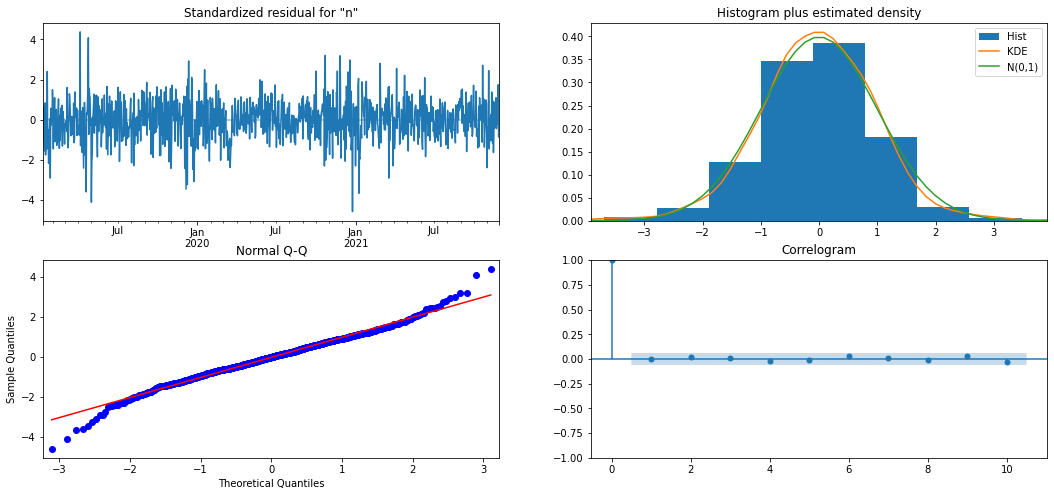

In [27]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

<AxesSubplot:xlabel='datetime'>

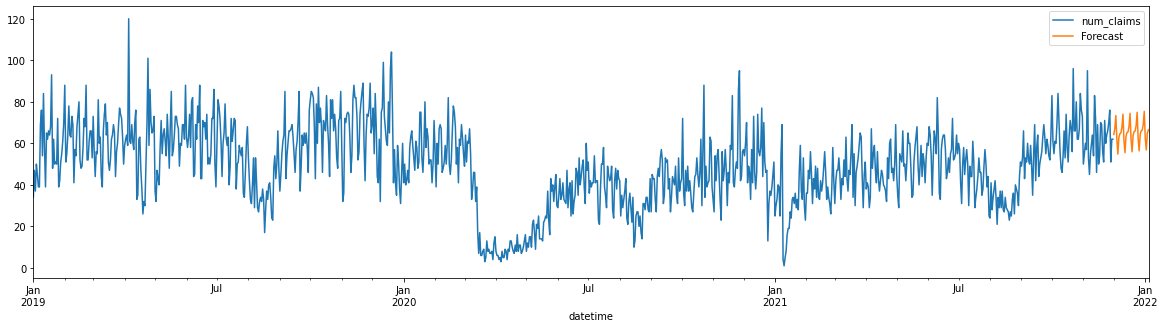

In [28]:
forecast = results.predict(start = len(train_graf), 
                          end = (len(train_graf)-1) + 3 * 12,
                         typ = 'levels').rename('Forecast')
  
train_graf.plot(figsize = (20, 5), legend = True)
forecast.plot(legend = True)

<AxesSubplot:xlabel='datetime'>

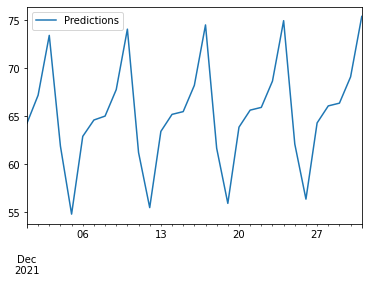

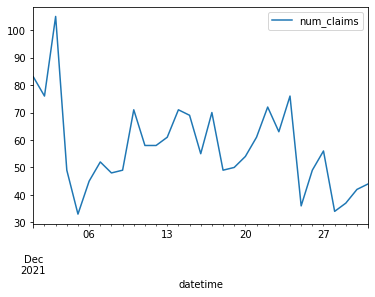

In [29]:
start = len(train_graf)
end = len(train_graf) + len(test_graf) - 1
  
predictions = results.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
predictions.plot(legend = True)
test_graf.plot(legend = True)

Evaluación de los resultados obtenidos:

In [30]:
rmse(test_graf, predictions)

array([17.14916762, 18.5277278 , 22.47101184, 16.3256234 , 15.86005949,
       16.64062739, 17.28903432, 17.464337  , 18.84379996, 22.93978473,
       16.15282645, 15.76877987, 16.82197174, 17.54454354, 17.67488511,
       19.09444458, 23.26390073, 16.26571837, 15.72473979, 16.9873017 ,
       17.74710437, 17.88299821, 19.3495304 , 23.59125369, 16.38963351,
       15.69293636, 17.16233568, 17.95817687, 18.09943072, 19.61118424,
       23.92223092])

In [31]:
mean_squared_error(test_graf, predictions)

266.43284197378534

In [32]:
mean_absolute_error(test_graf, predictions)

13.093809926761141

In [33]:
mean_absolute_percentage_error(test_graf, predictions)

0.2743525624796684

## B. PROPHET

Prophet es una libreria de código abierto generada por Facebook utilizada para pronosticar datos de series de tiempo. Se basa en un modelo aditivo descomponible donde las tendencias no lineales se ajustan a la estacionalidad, y donde también podremos incluir otras variables exogenas como las vacaciones.

Para mas información adjuntamos el siguiente link:
https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [34]:
accidents['fecha_datetime'] = pd.to_datetime(accidents['fecha_datetime'], format='%Y-%m-%d')
accidents.rename(columns={'fecha_datetime':'ds', 'num_claims':'y'}, inplace=True)

In [35]:
prophet_df = accidents[['ds','y']]

Incluimos un dataset de todos los festivos de Madrid, en el que tambien incluiremos una ventana de su efecto de -1 y 1, ya que los desplazamientos por vacaciones suelen ocurrir no solo en los dias festivos, sino tambien los dias cercanos.

In [36]:
#dataframe de los festivos
holidays = accidents[['ds','es_fest']]
holidays = holidays[holidays['es_fest']==True].reset_index(drop=True)
holidays.rename(columns={'es_fest':'holiday'}, inplace=True)
holidays['holiday']='Festivo'
holidays['lower_window']=-1
holidays['upper_window']=1

Del analisis exploratorio sabemos que el comportamiento difiere notablemente de los dias laborables a los dias del fin de semana. Para ello incluiremos un regresor que distinga de dias laborables a los que no.

In [37]:
#Añadimos como regresor si es fin de semana
def findesem(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 or date.weekday() == 5:
        return 1
    else:
        return 0

In [38]:
prophet_df['findesem'] = prophet_df['ds'].apply(findesem)

Debido al caracter excepcional y el gran impacto que  el periodo de confinamiento ha tenido sobre la variable, habría dos formas de tratarlo:
- eliminando dicho periodo
- aplicando un regresor extra

Considero que es mejor aplicalo como un regresor, puesto que dicho DC tiene un impacto directo en los meses siguientes.

In [39]:
#Añadimos como regresor el periodo de cuarentena por pandemia del COVID
def covid_cuarentena(ds):
    date = pd.to_datetime(ds)
    date_covid0=pd.to_datetime('2020-03-15',  format='%Y-%m-%d')
    date_covid1=pd.to_datetime('2020-05-09',  format='%Y-%m-%d')
    if (date > date_covid0) and (date < date_covid1):
        return 1
    return 0

In [40]:
prophet_df['covid_cuarentena'] = prophet_df['ds'].apply(covid_cuarentena)

In [41]:
train = prophet_df.iloc[:(len(prophet_df)-31)]
test = prophet_df.iloc[(len(prophet_df)-31):]

In [42]:
# define the model
model = Prophet(holidays = holidays)
model.add_regressor('findesem')
model.add_regressor('covid_cuarentena')

In [43]:
# fit the model
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -19.6395
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


      99       2047.23    0.00113963       57.8189           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       2049.64    0.00026515       77.1606   3.145e-06       0.001      286  LS failed, Hessian reset 
     199       2049.65   4.28611e-05       48.4729      0.5409      0.5409      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2049.71    0.00034072       68.5957           1           1      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       2049.73   0.000212114       76.4083   2.379e-06       0.001      480  LS failed, Hessian reset 
     399       2049.81   2.59967e-05       62.9453      0.7264      0.7264      602   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       2049.81   3.03089e-07        53.583      0.2903

In [44]:
future = model.make_future_dataframe(periods=31, freq='D')

In [45]:
future['findesem'] = future['ds'].apply(findesem)
future['covid_cuarentena'] = future['ds'].apply(covid_cuarentena)

In [46]:
forecast = model.predict(future) 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
1091,2021-12-27,57.385006,44.083556,70.894568,57.673695,57.594574,57.747939
1092,2021-12-28,59.304015,46.012046,73.161397,57.717927,57.632400,57.797936
1093,2021-12-29,59.234281,44.998694,72.493415,57.762159,57.672237,57.847033
1094,2021-12-30,59.767186,46.244000,72.823392,57.806391,57.706501,57.898545
1095,2021-12-31,64.599106,51.934247,78.354221,57.850623,57.740336,57.950377


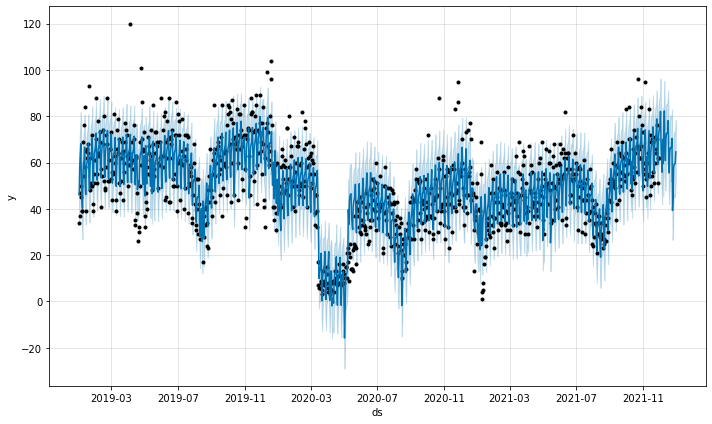

In [47]:
fig1 = model.plot(forecast) 

<AxesSubplot:xlabel='ds'>

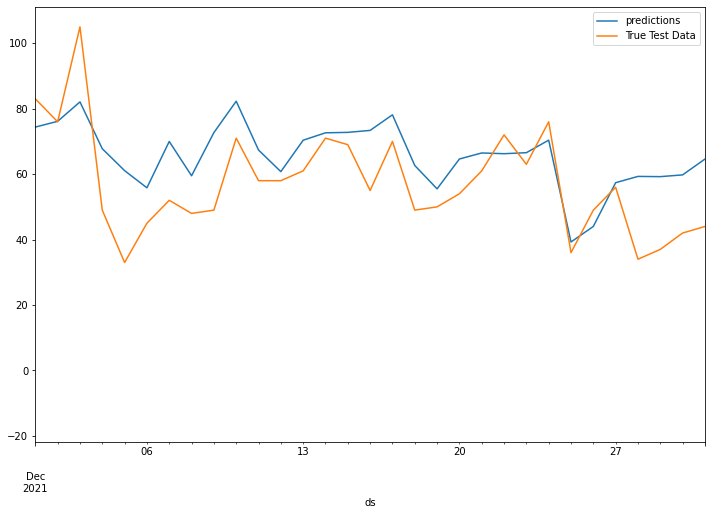

In [48]:
ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8),xlim=('2021-12-01','2021-12-31'))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax, xlim=('2021-12-01','2021-12-31'))

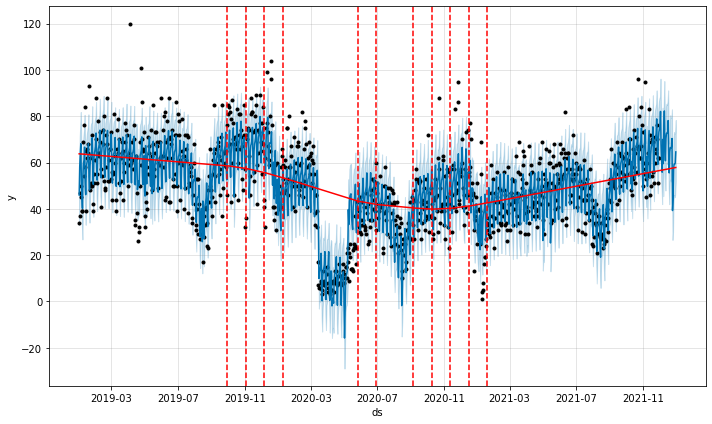

In [49]:
# changing trend points
fig=model.plot(forecast)
a=add_changepoints_to_plot(fig.gca(),model,forecast)

In [50]:
#Efecto de las vacaciones sobre las predicciones
forecast[(forecast['Festivo']).abs() > 0][
        ['ds', 'Festivo']][-10:]

,ds,Festivo
1043,2021-11-09,-16.199705
1044,2021-11-10,-4.232173
1069,2021-12-05,-0.704232
1070,2021-12-06,-16.199705
1071,2021-12-07,-4.936405
1072,2021-12-08,-16.199705
1073,2021-12-09,-4.232173
1088,2021-12-24,-0.704232
1089,2021-12-25,-16.199705
1090,2021-12-26,-4.232173


In [51]:
#Efecto de las vacaciones sobre las predicciones
forecast[(forecast['findesem']).abs() > 0][
        ['ds', 'findesem']][-10:]

,ds,findesem
1061,2021-11-27,2.729766
1062,2021-11-28,2.729766
1068,2021-12-04,2.729766
1069,2021-12-05,2.729766
1075,2021-12-11,2.729766
1076,2021-12-12,2.729766
1082,2021-12-18,2.729766
1083,2021-12-19,2.729766
1089,2021-12-25,2.729766
1090,2021-12-26,2.729766


Descomponemos la serie en los elementos:
- tendencia
- anual
- semanal
- efecto de las vacaciones

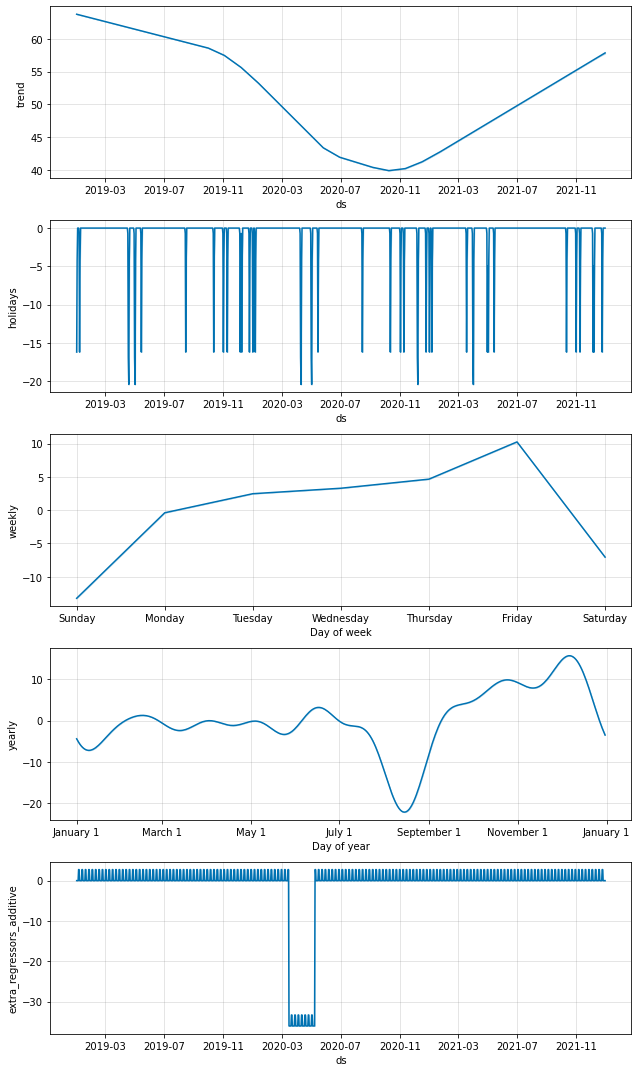

In [52]:
fig = model.plot_components(forecast)

Evaluación del modelo:

In [53]:
df_merge = pd.merge(prophet_df, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2019-01-01,32.968659,59.249078,45.966725,34
1,2019-01-02,44.863378,71.193252,58.060403,47
2,2019-01-03,49.754780,75.956704,63.041562,37
3,2019-01-04,55.166451,81.804997,68.105256,50
4,2019-01-05,40.318304,66.163138,53.070861,45


In [54]:
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
mae_01 = mean_absolute_error(y_true, y_pred)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print(mae_01)
print(mape_01)

8.085810792813175
0.2543281784376655


Diagnóstico del modelo por medio del **Cross validation**, donde:
- hemos cogido el parallel processes de todos los posibles, ya que nuestra muestra no es muy grande
- los parametros son:
    - initial: donde comienza el trainning, hemos querido descartar el año de la pandemia
    - period: numero de dias entre los cortes
    - horizon: periodo de forecasting, diciembre 2021

In [55]:
df_cv = cross_validation(model, initial='730 days', period='7 days', horizon = '31 days', parallel="processes");

INFO:prophet:Making 44 forecasts with cutoffs between 2021-01-02 00:00:00 and 2021-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9648b60f10>


Initial log joint probability = -19.638
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1423.78    0.00451074       80.5627      0.7826      0.7826      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1424.19   2.44736e-05       63.7672           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206        1424.2   2.98933e-05       85.5301   3.358e-07       0.001      283  LS failed, Hessian reset 
     299       1424.29   2.52525e-07        70.587      0.2752      0.2752      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       1424.29   8.01135e-08       74.9765      0.7237      0.7237      418   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabili

Initial log joint probability = -18.0288
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1518.83    0.00129316        84.157      0.8151      0.8151      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       1519.28   0.000899451        110.61   1.111e-05       0.001      219  LS failed, Hessian reset 
     199       1519.45   7.04716e-08       71.4906       0.101       0.101      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       1519.45   1.76159e-06       73.8998   2.003e-08       0.001      378  LS failed, Hessian reset 
     247       1519.45   3.34525e-08       76.1746      0.2885           1      407   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.1619
    Iter      log prob        ||dx||      ||grad||   

     299       1567.49    9.5754e-07       50.9766      0.3934      0.3934      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323        1567.5    8.5754e-05       69.4261    1.83e-06       0.001      611  LS failed, Hessian reset 
     391       1567.53   2.61021e-06        55.026   4.752e-08       0.001      743  LS failed, Hessian reset 
     399       1567.53   2.72287e-08       39.1603      0.1921      0.1921      754   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     400       1567.53   6.67112e-08       41.6632     0.07905      0.3223      756   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.2505
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       1579.67    0.00103889       119.228   1.377e-05       0.001      148  LS failed

Initial log joint probability = -19.5712
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1681.78    0.00535892       74.9517           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       1682.09   0.000714403       53.8069    1.22e-05       0.001      197  LS failed, Hessian reset 
     157       1682.21   7.40113e-05       65.7702   1.423e-06       0.001      276  LS failed, Hessian reset 
     199       1682.24    0.00038623       59.6806           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       1682.74   0.000463904       90.7194   3.775e-06       0.001      444  LS failed, Hessian reset 
     280       1682.79     5.856e-06       45.0753   9.842e-08       0.001      536  LS failed, Hessian reset 
     297       1682.79   1.14017e-07       42.6511      0.7669   

Initial log joint probability = -20.2484
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73        1780.1    0.00049467       99.6183   5.297e-06       0.001      118  LS failed, Hessian reset 
      99        1780.4    0.00190416       60.3611      0.7741      0.7741      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       1781.15   0.000260651       83.9088    5.79e-06       0.001      307  LS failed, Hessian reset 
     199       1781.26   2.85416e-06       55.1863           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       1781.26   9.98078e-06       51.7893   2.021e-07       0.001      419  LS failed, Hessian reset 
     215       1781.26   5.54306e-07       34.0632    1.26e-08       0.001      475  LS failed, Hessian reset 
     219       1781.26   7.75855e-08       41.0332     0.07538   

Initial log joint probability = -18.5283
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1871.73    0.00104753       54.4287      0.7833      0.7833      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1873.52   0.000248166       51.6774       4.638      0.4638      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.0778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       1885.99   0.000467451       86.9887   7.864e-06       0.001      113  LS failed, Hessian reset 
     239       1873.56   8.99271e-07        36.004   2.115e-08       0.001      355  LS failed, Hessian reset 
      99       1887.42    0.00290697       60.5875           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha     

     299       1949.18   2.20669e-05       52.0121      0.2021      0.2021      557   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     390       1949.35   0.000431044       100.422   5.728e-06       0.001      726  LS failed, Hessian reset 
     399        1949.4   8.94781e-05       36.1709        1.32       0.132      738   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     457       1949.47    6.0927e-08       57.9221      0.3628           1      831   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.8618
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1960.72    0.00187516         91.36           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       1962.88   0

In [56]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-03,24.854232,12.591732,37.533476,33,2021-01-02
1,2021-01-04,35.965127,22.991408,48.918516,40,2021-01-02
2,2021-01-05,36.660566,23.724974,49.835775,39,2021-01-02
3,2021-01-06,21.882702,8.847318,35.337911,25,2021-01-02
4,2021-01-07,35.017955,22.432197,48.498314,55,2021-01-02


In [57]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,99.923565,9.996178,7.511357,0.253801,0.119839,0.178505,0.808155
1,5 days,120.450342,10.974987,8.570638,0.221389,0.148337,0.190712,0.795455
2,6 days,141.071785,11.877364,9.567845,0.217159,0.171996,0.202156,0.731283
3,7 days,178.977282,13.378239,10.602118,0.277266,0.184658,0.241263,0.691845
4,8 days,185.090300,13.604790,10.936297,0.466557,0.216370,0.278630,0.661765


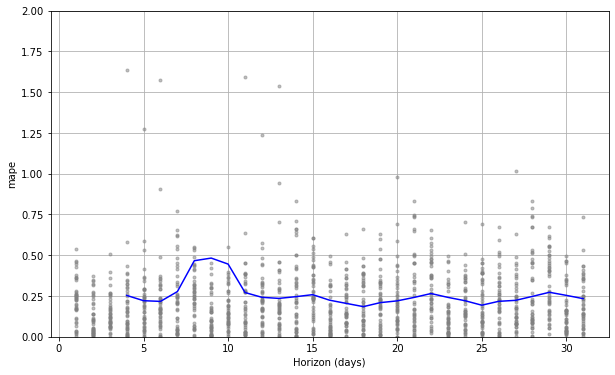

In [58]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.ylim(0,2);

Vamos a usar el grid para buscar los mejores hiperparámetros
https://jadsmkbdatalab.nl/forecasting-with-facebook-prophet-models-an-intro/

In [59]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
            }

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAE for each params here
mapes = [] # Store the MAPE for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(prophet_df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mape'] = mapes

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9648975730>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1619.26   0.000468189       5103.44       0.339           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       1621.51   4.91775e-09       5106.83      0.2155      0.2155      192   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -9.04653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.04653             0        374.01       1e-12       0.001       27   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -108.643
Iteration  1. Log joint probability =    321.929. Improved by 430.572.
Initial log joint probability = -9.84478
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.84478             0       389.722       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -123.225
Iteration  2. Log joint probability =    498.419. Improved by 176.49.
Iteration  1. Log joint probability =     330.86. Improved by 454.085.
Iteration  3. Log join

Iteration 57. Log joint probability =    651.984. Improved by 0.000170303.
Iteration 58. Log joint probability =    651.984. Improved by 5.39052e-05.
Iteration 59. Log joint probability =    651.984. Improved by 5.92571e-05.
Iteration 60. Log joint probability =    651.984. Improved by 6.16822e-05.
Iteration 61. Log joint probability =    651.984. Improved by 3.81147e-05.
Iteration 62. Log joint probability =    651.984. Improved by 1.54276e-05.
Iteration 63. Log joint probability =    651.984. Improved by 8.93551e-06.
Iteration 64. Log joint probability =    651.984. Improved by 4.82078e-06.
Iteration 65. Log joint probability =    651.984. Improved by 8.47862e-08.
Iteration 66. Log joint probability =    651.984. Improved by 3.09972e-07.
Iteration 67. Log joint probability =    651.984. Improved by 2.53261e-06.
Iteration 68. Log joint probability =    651.984. Improved by 1.1793e-06.
Iteration 69. Log joint probability =    651.984. Improved by 4.23825e-09.


Initial log joint probability = -9.8252
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -9.8252             0       403.952       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -136.99
Iteration  1. Log joint probability =    314.405. Improved by 451.395.
Iteration  2. Log joint probability =    543.834. Improved by 229.429.
Iteration  3. Log joint probability =    631.663. Improved by 87.8294.
Iteration  4. Log joint probability =    685.541. Improved by 53.8773.
Iteration  5. Log joint probability =    701.048. Improved by 15.5075.
Iteration  6. Log joint probability =     701.15. Improved by 0.10191.
Iteration  7. Log joint probability =    701.566. Improved by 0.416261.
Iteration  8. Log joint probability =    711.172. Improved by 9.60546.
Iteration  9. Log joint probability =    711.344. 

Initial log joint probability = -11.4368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.4368             0        435.27       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -166.169
Iteration  1. Log joint probability =     363.69. Improved by 529.86.
Iteration  2. Log joint probability =    587.694. Improved by 224.004.
Iteration  3. Log joint probability =    750.549. Improved by 162.855.
Initial log joint probability = -28.8311
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -28.8311             0       471.916       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -197.348
Iteration  4. Log join

Initial log joint probability = -27.1095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -27.1095             0       478.223       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -209.41
Iteration  1. Log joint probability =      121.5. Improved by 330.91.
Iteration  2. Log joint probability =    591.298. Improved by 469.798.
Iteration  3. Log joint probability =    700.481. Improved by 109.183.
Iteration  4. Log joint probability =    702.731. Improved by 2.24988.
Iteration  5. Log joint probability =    716.633. Improved by 13.9023.
Iteration  6. Log joint probability =    720.821. Improved by 4.18712.
Iteration  7. Log joint probability =    720.922. Improved by 0.101565.
Iteration  8. Log joint probability =    720.996. Improved by 0.0738971.
Iteration  9. Log joint probability =    721.066

Iteration 24. Log joint probability =    721.147. Improved by 0.000102583.
Iteration 25. Log joint probability =    721.147. Improved by 4.22765e-05.
Iteration 26. Log joint probability =    721.147. Improved by 5.93517e-05.
Initial log joint probability = -25.5792
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -25.5792             0       486.255       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -221.664
Iteration 27. Log joint probability =    721.147. Improved by 3.87059e-05.
Iteration  1. Log joint probability =      338.6. Improved by 560.264.
Iteration 28. Log joint probability =    721.147. Improved by 1.58504e-05.
Iteration  2. Log joint probability =    561.302. Improved by 222.702.
Iteration 29. Log joint probability =    721.147. Improved by 7.65711e-06.
Iteration  3. Log joint p

Initial log joint probability = -26.2668
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -26.2668             0       498.917       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -236.136
Iteration  1. Log joint probability =    353.182. Improved by 589.318.
Iteration  2. Log joint probability =    595.802. Improved by 242.62.
Iteration  3. Log joint probability =     732.12. Improved by 136.318.
Iteration  4. Log joint probability =    739.415. Improved by 7.295.
Iteration  5. Log joint probability =    746.761. Improved by 7.34555.
Iteration  6. Log joint probability =    748.091. Improved by 1.32998.
Iteration  7. Log joint probability =     748.35. Improved by 0.259012.
Iteration  8. Log joint probability =    748.367. Improved by 0.0173437.
Iteration  9. Log joint probability =    748.713.

Initial log joint probability = -19.8071
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -19.8071             0       575.031       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -312.38
Iteration  1. Log joint probability =    447.607. Improved by 759.987.
Iteration  2. Log joint probability =    772.046. Improved by 324.439.
Iteration  3. Log joint probability =    892.296. Improved by 120.25.
Iteration  4. Log joint probability =    902.973. Improved by 10.6768.
Iteration  5. Log joint probability =    910.701. Improved by 7.72808.
Iteration  6. Log joint probability =    916.052. Improved by 5.35098.
Iteration  7. Log joint probability =    916.518. Improved by 0.466261.
Iteration  8. Log joint probability =     917.12. Improved by 0.602092.
Iteration  9. Log joint probability =    917.568.

Iteration 25. Log joint probability =    918.119. Improved by 0.000561293.
Iteration 26. Log joint probability =     918.12. Improved by 0.000269765.
Initial log joint probability = -23.8901
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -23.8901             0       595.057       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -330.247
Iteration 27. Log joint probability =     918.12. Improved by 0.000158245.
Iteration  1. Log joint probability =    439.257. Improved by 769.505.
Iteration 28. Log joint probability =     918.12. Improved by 5.44684e-05.
Iteration  2. Log joint probability =    780.717. Improved by 341.46.
Iteration 29. Log joint probability =     918.12. Improved by 2.66214e-05.
Iteration 30. Log joint probability =     918.12. Improved by 1.78497e-05.
Iteration  3. Log joint pr

Initial log joint probability = -16.5014
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       955.585     0.0191979       4804.73      0.7326      0.7326      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124        1023.7    0.00307164       5021.88   6.168e-07       0.001      187  LS failed, Hessian reset 
     193       1033.68   5.73614e-07       5018.12   1.145e-10       0.001      322  LS failed, Hessian reset 
     199       1033.68   7.10705e-08       5041.33      0.5279      0.5279      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       1033.68   9.83867e-09       5055.15      0.3942      0.3942      332   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.4652
    Iter      log prob        ||dx||      ||grad||    

Initial log joint probability = -19.6361
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -19.6361             0        704.53       1e-12       0.001       30   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -436.266
Iteration  1. Log joint probability =    599.608. Improved by 1035.87.
Iteration  2. Log joint probability =    1031.03. Improved by 431.422.
Iteration  3. Log joint probability =    1140.59. Improved by 109.556.
Iteration  4. Log joint probability =    1145.03. Improved by 4.44243.
Iteration  5. Log joint probability =     1149.1. Improved by 4.07384.
Iteration  6. Log joint probability =    1155.14. Improved by 6.04329.
Iteration  7. Log joint probability =    1155.24. Improved by 0.0903603.
Iteration  8. Log joint probability =    1156.77. Improved by 1.53815.
Iteration  9. Log joint probability =    1157.0

Initial log joint probability = -18.4928
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1192.65   4.16316e-06        5257.6      0.4618      0.4618      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       1192.69   3.74244e-09       5014.23      0.1868      0.1868      163   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -17.5156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1297.72   4.78157e-06       4799.36      0.2635           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1297.73   2.47167e-09       5204.21      0.2142      0.2142      150   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below to

Initial log joint probability = -29.4984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       1612.75   8.56587e-05       4790.82    1.66e-08       0.001      123  LS failed, Hessian reset 
      99       1613.14   1.27072e-07       4835.95      0.8024      0.8024      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       1613.14   8.00854e-09       4748.74       0.622       0.622      177   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f963f5b2280>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71        1672.6    0.00169426       4866.29    3.21e-07       0.001      124  LS failed, Hessian reset 
      99       1677.78   1.29764e-05       4922.31           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       1677.81   8.12811e-09        4364.6      0.2451      0.2451      199   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -9.04653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.04653             0        374.01       1e-12       0.001       27   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -168.51
Iteration  1. Log joint probability =    334.242. Improved by 502.752.
Iteration  2. Log joint probability =    498.086. Improved by 163.844.
Initial log joint probability = -9.84478
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =     710.08. Improved by 211.994.
       1      -9.84478             0       389.722       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -183.092
Iteration  4. Log join

Iteration 49. Log joint probability =    742.176. Improved by 0.000448873.
Iteration 58. Log joint probability =    714.105. Improved by 0.000271607.
Iteration 50. Log joint probability =    742.185. Improved by 0.00953894.
Iteration 59. Log joint probability =    714.109. Improved by 0.00459841.
Iteration 51. Log joint probability =    742.186. Improved by 0.00040372.
Iteration 60. Log joint probability =    714.109. Improved by 0.000244917.
Iteration 52. Log joint probability =    742.195. Improved by 0.00950317.
Iteration 61. Log joint probability =    714.114. Improved by 0.00454993.
Iteration 62. Log joint probability =    714.114. Improved by 0.000218821.
Iteration 53. Log joint probability =    742.196. Improved by 0.00035891.
Iteration 63. Log joint probability =    714.119. Improved by 0.00450203.
Iteration 54. Log joint probability =    742.205. Improved by 0.00946774.
Iteration 64. Log joint probability =    714.119. Improved by 0.000193309.
Iteration 55. Log joint probabili

Iteration 113. Log joint probability =    714.202. Improved by 0.000249582.
Iteration 107. Log joint probability =     742.37. Improved by 0.00257962.
Iteration 108. Log joint probability =    742.372. Improved by 0.00167762.
Iteration 114. Log joint probability =    714.202. Improved by 0.000238883.
Iteration 109. Log joint probability =    742.375. Improved by 0.00255995.
Iteration 115. Log joint probability =    714.202. Improved by 0.000252479.
Iteration 110. Log joint probability =    742.376. Improved by 0.00168016.
Iteration 116. Log joint probability =    714.202. Improved by 0.000235041.
Iteration 111. Log joint probability =    742.379. Improved by 0.00254031.
Iteration 117. Log joint probability =    714.203. Improved by 0.000255376.
Iteration 112. Log joint probability =    742.381. Improved by 0.00168274.
Iteration 118. Log joint probability =    714.203. Improved by 0.0002312.
Iteration 113. Log joint probability =    742.383. Improved by 0.0025207.
Iteration 119. Log joi

Iteration 170. Log joint probability =    714.215. Improved by 0.000131648.
Iteration 163. Log joint probability =    742.483. Improved by 0.00209719.
Iteration 171. Log joint probability =    714.216. Improved by 0.000333955.
Iteration 164. Log joint probability =    742.485. Improved by 0.00170528.
Iteration 165. Log joint probability =    742.487. Improved by 0.00208087.
Iteration 172. Log joint probability =    714.216. Improved by 0.000127831.
Iteration 166. Log joint probability =    742.488. Improved by 0.00170637.
Iteration 173. Log joint probability =    714.216. Improved by 0.000336394.
Iteration 167. Log joint probability =     742.49. Improved by 0.00206457.
Iteration 174. Log joint probability =    714.216. Improved by 0.000124978.
Iteration 168. Log joint probability =    742.492. Improved by 0.00170749.
Iteration 175. Log joint probability =    714.216. Improved by 0.000338207.
Iteration 169. Log joint probability =    742.494. Improved by 0.00204831.
Iteration 170. Log 

Iteration 222. Log joint probability =    714.227. Improved by 6.39564e-05.
Iteration 223. Log joint probability =     742.59. Improved by 0.00159597.
Iteration 224. Log joint probability =    742.592. Improved by 0.00177697.
Iteration 223. Log joint probability =    714.227. Improved by 0.000378332.
Iteration 225. Log joint probability =    742.593. Improved by 0.00157852.
Iteration 224. Log joint probability =    714.227. Improved by 6.14244e-05.
Iteration 226. Log joint probability =    742.595. Improved by 0.00178097.
Iteration 225. Log joint probability =    714.228. Improved by 0.000380014.
Iteration 227. Log joint probability =    742.597. Improved by 0.0015611.
Iteration 226. Log joint probability =    714.228. Improved by 5.88933e-05.
Iteration 228. Log joint probability =    742.599. Improved by 0.001785.
Iteration 227. Log joint probability =    714.228. Improved by 0.000381697.
Iteration 229. Log joint probability =      742.6. Improved by 0.00154371.
Iteration 228. Log joi

Iteration 275. Log joint probability =    714.242. Improved by 0.000609661.
Iteration 281. Log joint probability =    742.682. Improved by 0.00110094.
Iteration 276. Log joint probability =    714.242. Improved by 0.000390937.
Iteration 282. Log joint probability =    742.684. Improved by 0.00190379.
Iteration 277. Log joint probability =    714.243. Improved by 0.000447605.
Iteration 283. Log joint probability =    742.685. Improved by 0.00108426.
Iteration 278. Log joint probability =    714.243. Improved by 9.22614e-05.
Iteration 284. Log joint probability =    742.687. Improved by 0.00190676.
Iteration 279. Log joint probability =    714.243. Improved by 0.000293917.
Iteration 285. Log joint probability =    742.688. Improved by 0.00107117.
Iteration 280. Log joint probability =    714.243. Improved by 9.05065e-06.
Iteration 286. Log joint probability =     742.69. Improved by 0.0019079.
Iteration 281. Log joint probability =    714.243. Improved by 1.70862e-05.
Iteration 282. Log 

Iteration 333. Log joint probability =    714.244. Improved by 1.30162e-05.
Iteration 334. Log joint probability =    742.758. Improved by 0.00194084.
Iteration 334. Log joint probability =    714.244. Improved by 1.31921e-05.
Iteration 335. Log joint probability =    742.759. Improved by 0.000754981.
Iteration 335. Log joint probability =    714.244. Improved by 1.28597e-05.
Iteration 336. Log joint probability =    742.761. Improved by 0.0019425.
Iteration 336. Log joint probability =    714.244. Improved by 1.33455e-05.
Iteration 337. Log joint probability =    742.762. Improved by 0.000742629.
Iteration 337. Log joint probability =    714.244. Improved by 1.27032e-05.
Iteration 338. Log joint probability =    742.763. Improved by 0.00194418.
Iteration 338. Log joint probability =    714.244. Improved by 1.34989e-05.
Iteration 339. Log joint probability =    742.764. Improved by 0.0007303.
Iteration 339. Log joint probability =    714.244. Improved by 1.25466e-05.
Iteration 340. Log

Iteration 387. Log joint probability =    742.825. Improved by 0.000440736.
Iteration 393. Log joint probability =    714.244. Improved by 8.32029e-06.
Iteration 388. Log joint probability =    742.827. Improved by 0.00199295.
Iteration 394. Log joint probability =    714.244. Improved by 1.77939e-05.
Iteration 389. Log joint probability =    742.828. Improved by 0.000428926.
Iteration 395. Log joint probability =    714.244. Improved by 8.16376e-06.
Iteration 390. Log joint probability =     742.83. Improved by 0.00199516.
Iteration 396. Log joint probability =    714.244. Improved by 1.79473e-05.
Iteration 391. Log joint probability =     742.83. Improved by 0.000417134.
Iteration 397. Log joint probability =    714.244. Improved by 8.00723e-06.
Iteration 398. Log joint probability =    714.244. Improved by 1.81007e-05.
Iteration 392. Log joint probability =    742.832. Improved by 0.0019974.
Iteration 399. Log joint probability =    714.244. Improved by 7.85071e-06.
Iteration 393. L

Iteration 451. Log joint probability =    714.245. Improved by 3.78107e-06.
Iteration 440. Log joint probability =    742.887. Improved by 0.00205663.
Iteration 452. Log joint probability =    714.245. Improved by 2.22425e-05.
Iteration 441. Log joint probability =    742.887. Improved by 0.000128494.
Iteration 453. Log joint probability =    714.245. Improved by 3.62457e-06.
Iteration 442. Log joint probability =     742.89. Improved by 0.00205932.
Iteration 454. Log joint probability =    714.245. Improved by 2.23958e-05.
Iteration 443. Log joint probability =     742.89. Improved by 0.000117185.
Iteration 455. Log joint probability =    714.245. Improved by 3.46804e-06.
Iteration 444. Log joint probability =    742.892. Improved by 0.00206203.
Iteration 456. Log joint probability =    714.245. Improved by 2.25493e-05.
Iteration 445. Log joint probability =    742.892. Improved by 0.000105893.
Iteration 457. Log joint probability =    714.245. Improved by 3.31151e-06.
Iteration 446. 

Iteration 489. Log joint probability =     742.93. Improved by 0.00056252.
Iteration 511. Log joint probability =    714.246. Improved by 2.69568e-06.
Iteration 490. Log joint probability =    742.931. Improved by 0.000454258.
Iteration 512. Log joint probability =    714.246. Improved by 3.75719e-06.
Iteration 513. Log joint probability =    714.246. Improved by 2.72221e-06.
Iteration 491. Log joint probability =    742.931. Improved by 0.000564208.
Iteration 514. Log joint probability =    714.246. Improved by 3.73046e-06.
Iteration 492. Log joint probability =    742.932. Improved by 0.000450569.
Iteration 515. Log joint probability =    714.246. Improved by 2.74874e-06.
Iteration 516. Log joint probability =    714.246. Improved by 3.70375e-06.
Iteration 493. Log joint probability =    742.932. Improved by 0.000565898.
Iteration 494. Log joint probability =    742.933. Improved by 0.000446881.
Iteration 517. Log joint probability =    714.246. Improved by 2.77527e-06.
Iteration 518

Iteration 565. Log joint probability =    714.246. Improved by 3.41195e-06.
Iteration 546. Log joint probability =    742.959. Improved by 0.000351707.
Iteration 566. Log joint probability =    714.246. Improved by 3.03568e-06.
Iteration 547. Log joint probability =    742.959. Improved by 0.000612281.
Iteration 548. Log joint probability =    742.959. Improved by 0.000348072.
Iteration 567. Log joint probability =    714.246. Improved by 3.43846e-06.
Iteration 549. Log joint probability =     742.96. Improved by 0.000614026.
Iteration 568. Log joint probability =    714.246. Improved by 3.00896e-06.
Iteration 550. Log joint probability =     742.96. Improved by 0.00034444.
Iteration 569. Log joint probability =    714.246. Improved by 3.465e-06.
Iteration 551. Log joint probability =    742.961. Improved by 0.000615773.
Iteration 570. Log joint probability =    714.246. Improved by 2.98223e-06.
Iteration 552. Log joint probability =    742.961. Improved by 0.00034081.
Iteration 571. L

Iteration 622. Log joint probability =    714.246. Improved by 2.27516e-06.
Iteration 607. Log joint probability =    742.987. Improved by 0.000665436.
Iteration 608. Log joint probability =    742.987. Improved by 0.00023992.
Iteration 623. Log joint probability =    714.246. Improved by 4.20342e-06.
Iteration 609. Log joint probability =    742.988. Improved by 0.000667236.
Iteration 624. Log joint probability =    714.246. Improved by 2.22871e-06.
Iteration 610. Log joint probability =    742.988. Improved by 0.000236344.
Iteration 625. Log joint probability =    714.246. Improved by 4.24967e-06.
Iteration 611. Log joint probability =    742.989. Improved by 0.000669038.
Iteration 626. Log joint probability =    714.246. Improved by 2.18226e-06.
Iteration 612. Log joint probability =    742.989. Improved by 0.000232769.
Iteration 627. Log joint probability =    714.246. Improved by 4.29594e-06.
Iteration 613. Log joint probability =     742.99. Improved by 0.000670842.
Iteration 628

Iteration 678. Log joint probability =    714.247. Improved by 1.59025e-06.
Iteration 669. Log joint probability =    743.014. Improved by 0.000722047.
Iteration 679. Log joint probability =    714.247. Improved by 4.85751e-06.
Iteration 670. Log joint probability =    743.015. Improved by 0.000129864.
Iteration 671. Log joint probability =    743.015. Improved by 0.0007239.
Iteration 680. Log joint probability =    714.247. Improved by 1.59457e-06.
Iteration 672. Log joint probability =    743.015. Improved by 0.000126341.
Iteration 681. Log joint probability =    714.247. Improved by 4.85301e-06.
Iteration 673. Log joint probability =    743.016. Improved by 0.000725756.
Iteration 682. Log joint probability =    714.247. Improved by 1.59887e-06.
Iteration 674. Log joint probability =    743.016. Improved by 0.00012282.
Iteration 683. Log joint probability =    714.247. Improved by 4.84852e-06.
Iteration 675. Log joint probability =    743.017. Improved by 0.000727612.
Iteration 684. 

Iteration 728. Log joint probability =    743.039. Improved by 5.16324e-05.
Iteration 732. Log joint probability =    714.247. Improved by 1.70642e-06.
Iteration 729. Log joint probability =    743.039. Improved by 0.000754189.
Iteration 733. Log joint probability =    714.247. Improved by 4.73611e-06.
Iteration 730. Log joint probability =    743.039. Improved by 4.99918e-05.
Iteration 734. Log joint probability =    714.247. Improved by 1.71073e-06.
Iteration 731. Log joint probability =     743.04. Improved by 0.000754256.
Iteration 735. Log joint probability =    714.247. Improved by 4.73161e-06.
Iteration 732. Log joint probability =     743.04. Improved by 4.83527e-05.
Iteration 736. Log joint probability =    714.247. Improved by 1.71502e-06.
Iteration 733. Log joint probability =    743.041. Improved by 0.000754325.
Iteration 737. Log joint probability =    714.247. Improved by 4.72712e-06.
Iteration 734. Log joint probability =    743.041. Improved by 4.67153e-05.
Iteration 73

Iteration 788. Log joint probability =    714.247. Improved by 1.82689e-06.
Iteration 780. Log joint probability =    743.059. Improved by 9.48126e-06.
Iteration 789. Log joint probability =    714.247. Improved by 4.61021e-06.
Iteration 781. Log joint probability =     743.06. Improved by 0.000756442.
Iteration 790. Log joint probability =    714.247. Improved by 1.8312e-06.
Iteration 782. Log joint probability =     743.06. Improved by 7.88066e-06.
Iteration 791. Log joint probability =    714.247. Improved by 4.6057e-06.
Iteration 783. Log joint probability =    743.061. Improved by 0.000756514.
Iteration 792. Log joint probability =    714.247. Improved by 1.83551e-06.
Iteration 793. Log joint probability =    714.247. Improved by 4.60121e-06.
Iteration 784. Log joint probability =    743.061. Improved by 6.34026e-06.
Iteration 794. Log joint probability =    714.247. Improved by 1.8398e-06.
Iteration 785. Log joint probability =    743.061. Improved by 0.000755783.
Iteration 795. 

Iteration 835. Log joint probability =    743.076. Improved by 5.26455e-06.
Iteration 842. Log joint probability =    714.247. Improved by 2.11638e-06.
Iteration 836. Log joint probability =    743.076. Improved by 5.32432e-07.
Iteration 843. Log joint probability =    714.247. Improved by 4.30147e-06.
Iteration 837. Log joint probability =    743.076. Improved by 5.25588e-06.
Iteration 844. Log joint probability =    714.247. Improved by 2.14876e-06.
Iteration 838. Log joint probability =    743.076. Improved by 5.41001e-07.
Iteration 845. Log joint probability =    714.247. Improved by 4.26889e-06.
Iteration 839. Log joint probability =    743.076. Improved by 5.24724e-06.
Iteration 846. Log joint probability =    714.247. Improved by 2.18114e-06.
Iteration 840. Log joint probability =    743.076. Improved by 5.49574e-07.
Iteration 847. Log joint probability =    714.247. Improved by 4.23633e-06.
Iteration 841. Log joint probability =    743.076. Improved by 5.23858e-06.
Iteration 84

Iteration 891. Log joint probability =    743.077. Improved by 4.92492e-06.
Iteration 896. Log joint probability =    714.247. Improved by 2.93391e-06.
Iteration 897. Log joint probability =    714.247. Improved by 3.48947e-06.
Iteration 892. Log joint probability =    743.077. Improved by 8.75796e-07.
Iteration 898. Log joint probability =    714.247. Improved by 2.94476e-06.
Iteration 899. Log joint probability =    714.247. Improved by 3.47844e-06.
Iteration 893. Log joint probability =    743.077. Improved by 4.90385e-06.
Iteration 900. Log joint probability =    714.247. Improved by 2.9556e-06.
Iteration 894. Log joint probability =    743.077. Improved by 8.96794e-07.
Iteration 901. Log joint probability =    714.247. Improved by 3.46739e-06.
Iteration 895. Log joint probability =    743.077. Improved by 4.88275e-06.
Iteration 902. Log joint probability =    714.247. Improved by 2.96646e-06.
Iteration 896. Log joint probability =    743.077. Improved by 9.17782e-07.
Iteration 903

Iteration 954. Log joint probability =    714.248. Improved by 3.51444e-06.
Iteration 947. Log joint probability =    743.077. Improved by 4.33453e-06.
Iteration 955. Log joint probability =    714.248. Improved by 2.89083e-06.
Iteration 948. Log joint probability =    743.077. Improved by 1.46372e-06.
Iteration 956. Log joint probability =    714.248. Improved by 3.55032e-06.
Iteration 949. Log joint probability =    743.077. Improved by 4.31344e-06.
Iteration 957. Log joint probability =    714.248. Improved by 2.85475e-06.
Iteration 950. Log joint probability =    743.077. Improved by 1.48472e-06.
Iteration 958. Log joint probability =    714.248. Improved by 3.5862e-06.
Iteration 951. Log joint probability =    743.077. Improved by 4.29236e-06.
Iteration 959. Log joint probability =    714.248. Improved by 2.81867e-06.
Iteration 952. Log joint probability =    743.077. Improved by 1.50572e-06.
Iteration 960. Log joint probability =    714.248. Improved by 3.62209e-06.
Iteration 953

Iteration 1002. Log joint probability =    743.077. Improved by 2.20748e-06.
Iteration 1010. Log joint probability =    714.248. Improved by 4.51913e-06.
Iteration 1003. Log joint probability =    743.077. Improved by 3.56093e-06.
Iteration 1011. Log joint probability =    714.248. Improved by 1.88073e-06.
Iteration 1004. Log joint probability =    743.077. Improved by 2.24123e-06.
Iteration 1012. Log joint probability =    714.248. Improved by 4.55502e-06.
Iteration 1005. Log joint probability =    743.077. Improved by 3.52711e-06.
Iteration 1013. Log joint probability =    714.248. Improved by 1.84465e-06.
Iteration 1006. Log joint probability =    743.077. Improved by 2.27496e-06.
Iteration 1014. Log joint probability =    714.248. Improved by 4.5909e-06.
Iteration 1015. Log joint probability =    714.248. Improved by 1.80858e-06.
Iteration 1007. Log joint probability =    743.077. Improved by 3.49328e-06.
Iteration 1016. Log joint probability =    714.248. Improved by 4.62677e-06.


Iteration 1068. Log joint probability =    714.248. Improved by 5.55972e-06.
Iteration 1058. Log joint probability =    743.077. Improved by 2.781e-06.
Iteration 1059. Log joint probability =    743.077. Improved by 2.99469e-06.
Iteration 1069. Log joint probability =    714.248. Improved by 8.34548e-07.
Iteration 1060. Log joint probability =    743.077. Improved by 2.79524e-06.
Iteration 1070. Log joint probability =    714.248. Improved by 5.59559e-06.
Iteration 1061. Log joint probability =    743.077. Improved by 2.98037e-06.
Iteration 1071. Log joint probability =    714.248. Improved by 7.9848e-07.
Iteration 1062. Log joint probability =    743.077. Improved by 2.80948e-06.
Iteration 1072. Log joint probability =    714.248. Improved by 5.63148e-06.
Iteration 1063. Log joint probability =    743.077. Improved by 2.96604e-06.
Iteration 1073. Log joint probability =    714.248. Improved by 7.62397e-07.
Iteration 1064. Log joint probability =    743.077. Improved by 2.82372e-06.
It

Iteration 1120. Log joint probability =    743.077. Improved by 3.22229e-06.
Iteration 1121. Log joint probability =    743.077. Improved by 2.55068e-06.
Iteration 1122. Log joint probability =    743.077. Improved by 3.23652e-06.
Iteration 1123. Log joint probability =    743.077. Improved by 2.53636e-06.
Iteration 1124. Log joint probability =    743.077. Improved by 3.25076e-06.
Iteration 1125. Log joint probability =    743.077. Improved by 2.52204e-06.
Iteration 1126. Log joint probability =    743.077. Improved by 3.26498e-06.
Iteration 1127. Log joint probability =    743.077. Improved by 2.50772e-06.
Iteration 1128. Log joint probability =    743.077. Improved by 3.27921e-06.
Iteration 1129. Log joint probability =    743.077. Improved by 2.4934e-06.
Iteration 1130. Log joint probability =    743.077. Improved by 3.29345e-06.
Iteration 1131. Log joint probability =    743.077. Improved by 2.47907e-06.
Iteration 1132. Log joint probability =    743.077. Improved by 3.30769e-06.


Initial log joint probability = -9.8252
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 1158. Log joint probability =    743.077. Improved by 3.16516e-06.
       1       -9.8252             0       403.952       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -196.857
Iteration 1159. Log joint probability =    743.077. Improved by 2.62599e-06.
Iteration  1. Log joint probability =    374.885. Improved by 571.742.
Iteration 1160. Log joint probability =    743.077. Improved by 3.13969e-06.
Iteration  2. Log joint probability =    608.925. Improved by 234.04.
Iteration 1161. Log joint probability =    743.077. Improved by 2.65136e-06.
Iteration  3. Log joint probability =    715.155. Improved by 106.23.
Iteration 1162. Log joint probability =    743.077. Improved by 3.11041e-06.
Iteration  4. Log join

Iteration 51. Log joint probability =    773.421. Improved by 2.05397e-07.
Iteration 1217. Log joint probability =    743.077. Improved by 3.79507e-06.
Iteration 52. Log joint probability =    773.421. Improved by 1.3998e-07.
Iteration 1218. Log joint probability =    743.077. Improved by 1.96018e-06.
Iteration 53. Log joint probability =    773.421. Improved by 1.75713e-08.
Iteration 1219. Log joint probability =    743.077. Improved by 3.8362e-06.
Iteration 1220. Log joint probability =    743.077. Improved by 1.91895e-06.
Iteration 54. Log joint probability =    773.421. Improved by 7.17828e-08.
Iteration 1221. Log joint probability =    743.078. Improved by 3.87734e-06.
Iteration 55. Log joint probability =    773.421. Improved by 3.53871e-08.
Iteration 1222. Log joint probability =    743.078. Improved by 1.87774e-06.
Iteration 56. Log joint probability =    773.421. Improved by 1.90117e-08.
Iteration 1223. Log joint probability =    743.078. Improved by 3.91847e-06.
Iteration 57.

Initial log joint probability = -11.4368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.4368             0        435.27       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -226.037
Iteration 1306. Log joint probability =    743.078. Improved by 1.46338e-07.
Iteration  1. Log joint probability =    366.308. Improved by 592.344.
Iteration 1307. Log joint probability =    743.078. Improved by 5.64617e-06.
Iteration  2. Log joint probability =    634.284. Improved by 267.977.
Iteration 1308. Log joint probability =    743.078. Improved by 1.05129e-07.
Iteration 1309. Log joint probability =    743.078. Improved by 5.68729e-06.
Iteration  3. Log joint probability =    807.547. Improved by 173.263.
Iteration 1310. Log joint probability =    743.078. Improved by 6.38985e-08.
Iteration  4. Log j

Iteration 1373. Log joint probability =    743.078. Improved by 2.66772e-07.
Iteration 1374. Log joint probability =    743.078. Improved by 9.40375e-08.
Iteration 1375. Log joint probability =    743.078. Improved by 2.66577e-07.
Iteration 1376. Log joint probability =    743.078. Improved by 9.42332e-08.
Iteration 1377. Log joint probability =    743.078. Improved by 2.66383e-07.
Iteration 1378. Log joint probability =    743.078. Improved by 9.44151e-08.
Iteration 1379. Log joint probability =    743.078. Improved by 2.66203e-07.
Iteration 1380. Log joint probability =    743.078. Improved by 9.46083e-08.
Iteration 1381. Log joint probability =    743.078. Improved by 2.66003e-07.
Iteration 1382. Log joint probability =    743.078. Improved by 9.48029e-08.
Iteration 1383. Log joint probability =    743.078. Improved by 2.65816e-07.
Iteration 1384. Log joint probability =    743.078. Improved by 9.4999e-08.
Iteration 1385. Log joint probability =    743.078. Improved by 2.656e-07.
It

Iteration 1390. Log joint probability =    743.078. Improved by 9.53369e-08.
Iteration 1391. Log joint probability =    743.078. Improved by 2.65509e-07.
Iteration 1392. Log joint probability =    743.078. Improved by 9.44987e-08.
Initial log joint probability = -28.8311
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -28.8311             0       471.916       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -257.215
Iteration 1393. Log joint probability =    743.078. Improved by 2.66916e-07.
Iteration 1394. Log joint probability =    743.078. Improved by 9.31078e-08.
Iteration  1. Log joint probability =    326.614. Improved by 583.829.
Iteration 1395. Log joint probability =    743.078. Improved by 2.68279e-07.
Iteration  2. Log joint probability =    622.235. Improved by 295.621.
Iteration 139

Iteration 47. Log joint probability =    808.119. Improved by 0.000506386.
Iteration 1450. Log joint probability =    743.078. Improved by 5.43541e-08.
Iteration 1451. Log joint probability =    743.078. Improved by 3.07034e-07.
Iteration 48. Log joint probability =     808.12. Improved by 0.00023586.
Iteration 1452. Log joint probability =    743.078. Improved by 5.29699e-08.
Iteration 49. Log joint probability =     808.12. Improved by 0.000493018.
Iteration 1453. Log joint probability =    743.078. Improved by 3.08418e-07.
Iteration 50. Log joint probability =     808.12. Improved by 0.000294509.
Iteration 1454. Log joint probability =    743.078. Improved by 5.15861e-08.
Iteration 51. Log joint probability =    808.121. Improved by 0.000423953.
Iteration 1455. Log joint probability =    743.078. Improved by 3.09804e-07.
Iteration 1456. Log joint probability =    743.078. Improved by 5.02022e-08.
Iteration 52. Log joint probability =    808.121. Improved by 0.000374011.
Iteration 14

Iteration 97. Log joint probability =    808.127. Improved by 2.21937e-06.
Iteration 1512. Log joint probability =    743.078. Improved by 1.14565e-08.
Iteration 1513. Log joint probability =    743.078. Improved by 3.49928e-07.
Iteration 98. Log joint probability =    808.127. Improved by 6.91945e-07.
Iteration 99. Log joint probability =    808.127. Improved by 2.17926e-06.
Iteration 1514. Log joint probability =    743.078. Improved by 1.00578e-08.
Iteration 100. Log joint probability =    808.127. Improved by 8.52966e-07.
Iteration 1515. Log joint probability =    743.078. Improved by 3.51312e-07.
Iteration 1516. Log joint probability =    743.078. Improved by 8.69068e-09.
Iteration 101. Log joint probability =    808.127. Improved by 1.99356e-06.
Iteration 102. Log joint probability =    808.127. Improved by 1.012e-06.
Iteration 103. Log joint probability =    808.127. Improved by 1.8956e-06.
Iteration 104. Log joint probability =    808.127. Improved by 1.12032e-06.
Iteration 105

Iteration 136. Log joint probability =    808.127. Improved by 4.02694e-07.
Initial log joint probability = -27.1095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -27.1095             0       478.223       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -269.277
Iteration 137. Log joint probability =    808.127. Improved by 3.48626e-07.
Iteration  1. Log joint probability =    348.037. Improved by 617.315.
Iteration 138. Log joint probability =    808.127. Improved by 3.74589e-07.
Iteration  2. Log joint probability =     624.56. Improved by 276.523.
Iteration 139. Log joint probability =    808.127. Improved by 3.83077e-07.
Iteration  3. Log joint probability =    781.856. Improved by 157.295.
Iteration 140. Log joint probability =    808.127. Improved by 3.23422e-07.
Iteration  4. Log joint 

Initial log joint probability = -25.5792
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -25.5792             0       486.255       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -281.531
Iteration  1. Log joint probability =    276.765. Improved by 558.296.
Iteration  2. Log joint probability =    654.673. Improved by 377.908.
Iteration  3. Log joint probability =     798.32. Improved by 143.647.
Iteration  4. Log joint probability =    800.559. Improved by 2.23877.
Iteration  5. Log joint probability =    813.633. Improved by 13.0742.
Iteration  6. Log joint probability =    814.115. Improved by 0.481784.
Iteration  7. Log joint probability =    814.366. Improved by 0.25125.
Iteration  8. Log joint probability =    814.782. Improved by 0.415945.
Iteration  9. Log joint probability =    815.04

Iteration 23. Log joint probability =    817.042. Improved by 0.0140056.
Iteration 24. Log joint probability =    817.046. Improved by 0.00340453.
Iteration 25. Log joint probability =    817.054. Improved by 0.00776105.
Iteration 26. Log joint probability =    817.055. Improved by 0.00126597.
Initial log joint probability = -26.2668
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -26.2668             0       498.917       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -296.003
Iteration 27. Log joint probability =    817.059. Improved by 0.00379438.
Iteration  1. Log joint probability =    265.353. Improved by 561.356.
Iteration 28. Log joint probability =    817.059. Improved by 0.000775429.
Iteration  2. Log joint probability =    678.142. Improved by 412.789.
Iteration  3. Log joint probabi

Initial log joint probability = -17.3858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       771.138   1.88388e-05       5010.55   3.987e-09       0.001      150  LS failed, Hessian reset 
      99       771.223   1.22425e-06       4834.52      0.2061      0.5789      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       771.256   2.56634e-06       5192.45   5.458e-10       0.001      224  LS failed, Hessian reset 
     146       771.269   3.35106e-09       4765.38      0.3945      0.3945      264   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.1422
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       762.714   1.15412e-06       4591.21      0.2718           1      123   
    Iter      log prob        ||dx||      ||grad||    

Initial log joint probability = -19.8071
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -19.8071             0       575.031       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -372.248
Iteration  1. Log joint probability =    81.2918. Improved by 453.539.
Iteration  2. Log joint probability =    268.979. Improved by 187.687.
Iteration  3. Log joint probability =    992.088. Improved by 723.109.
Iteration  4. Log joint probability =    992.698. Improved by 0.610008.
Iteration  5. Log joint probability =    1000.91. Improved by 8.20919.
Iteration  6. Log joint probability =    1001.64. Improved by 0.729227.
Iteration  7. Log joint probability =    1001.74. Improved by 0.101422.
Iteration  8. Log joint probability =    1004.48. Improved by 2.74592.
Iteration  9. Log joint probability =    1005.

Iteration 11. Log joint probability =    1005.92. Improved by 0.395122.
Iteration 12. Log joint probability =    1005.97. Improved by 0.0529099.
Initial log joint probability = -23.8901
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -23.8901             0       595.057       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -390.115
Iteration 13. Log joint probability =    1006.19. Improved by 0.224411.
Iteration  1. Log joint probability =    480.786. Improved by 870.901.
Iteration 14. Log joint probability =    1006.31. Improved by 0.116696.
Iteration  2. Log joint probability =    801.507. Improved by 320.721.
Iteration 15. Log joint probability =     1006.4. Improved by 0.0920553.
Iteration  3. Log joint probability =    897.723. Improved by 96.2163.
Iteration 16. Log joint probability =    1

Initial log joint probability = -16.4171
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1108.23   2.85652e-05        4959.4      0.4773      0.4773      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       1109.08     0.0001435       5020.47   2.865e-08       0.001      165  LS failed, Hessian reset 
     130       1109.87   1.47663e-05        5000.1   2.868e-09       0.001      232  LS failed, Hessian reset 
     168       1109.97    4.0118e-09       5090.11      0.2745      0.2745      283   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.5014
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1020.1     0.0171432       5047.59      0.3356           1      115   
    Iter      log prob        ||dx||      ||grad||    

Initial log joint probability = -19.6361
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -19.6361             0        704.53       1e-12       0.001       30   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -496.133
Iteration  1. Log joint probability =    734.649. Improved by 1230.78.
Iteration  2. Log joint probability =    1095.87. Improved by 361.225.
Iteration  3. Log joint probability =    1239.48. Improved by 143.608.
Iteration  4. Log joint probability =    1242.74. Improved by 3.25574.
Iteration  5. Log joint probability =    1250.15. Improved by 7.41029.
Iteration  6. Log joint probability =    1252.85. Improved by 2.70225.
Iteration  7. Log joint probability =    1254.86. Improved by 2.0074.
Iteration  8. Log joint probability =    1255.31. Improved by 0.452308.
Iteration  9. Log joint probability =    1255.35.

Initial log joint probability = -19.1154
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1325.7   0.000287693       4950.19           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1362.13   5.28391e-06       4970.37       3.203      0.3203      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       1362.18   9.63965e-09       5015.27      0.4123           1      278   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.4928
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1348.2   1.95482e-05       4493.23      0.3434           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     

Initial log joint probability = -19.4986
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1560.91   0.000482141       5249.37           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150        1562.1   9.28961e-09       4804.36      0.8709      0.8709      180   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.2938
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1618.8   8.00523e-05       4631.09      0.6414      0.6414      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       1619.02   8.55489e-09       5010.96      0.2531           1      172   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below to

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f963f5ae7f0>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1663.83   1.30276e-05       4870.01           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       1673.11   0.000988434       4994.27   2.072e-07       0.001      213  LS failed, Hessian reset 
     199       1676.51   5.93339e-06       4770.71        0.16           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1730.11   0.000959562       5216.15      0.2531           1      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     348       1734.13   8.93743e-09        4740.8      0.3494      0.3494      472   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -9.04653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.04653             0        374.01       1e-12       0.001       27   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -228.377
Iteration  1. Log joint probability =    284.303. Improved by 512.681.
Iteration  2. Log joint probability =    548.859. Improved by 264.556.
Iteration  3. Log joint probability =    699.444. Improved by 150.585.
Initial log joint probability = -9.84478
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.84478             0       389.722       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -242.959
Iteration  4. Log joi

Iteration 63. Log joint probability =    714.875. Improved by 8.77006e-07.
Iteration 64. Log joint probability =    714.875. Improved by 2.69641e-06.
Iteration 65. Log joint probability =    714.875. Improved by 8.78276e-07.
Iteration 66. Log joint probability =    714.875. Improved by 2.69511e-06.
Iteration 67. Log joint probability =    714.875. Improved by 8.79548e-07.
Iteration 68. Log joint probability =    714.875. Improved by 2.6938e-06.
Iteration 69. Log joint probability =    714.875. Improved by 8.80823e-07.
Iteration 70. Log joint probability =    714.875. Improved by 2.69251e-06.
Iteration 71. Log joint probability =    714.875. Improved by 8.82096e-07.
Iteration 72. Log joint probability =    714.875. Improved by 2.69121e-06.
Iteration 73. Log joint probability =    714.875. Improved by 8.83375e-07.
Iteration 74. Log joint probability =    714.875. Improved by 2.68992e-06.
Iteration 75. Log joint probability =    714.875. Improved by 8.8463e-07.
Iteration 76. Log joint pro

Iteration 78. Log joint probability =    714.875. Improved by 2.68732e-06.
Iteration 79. Log joint probability =    714.875. Improved by 8.87173e-07.
Iteration 80. Log joint probability =    714.875. Improved by 2.68603e-06.
Iteration 81. Log joint probability =    714.875. Improved by 8.88454e-07.
Iteration 82. Log joint probability =    714.875. Improved by 2.68473e-06.
Initial log joint probability = -9.8252
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 83. Log joint probability =    714.875. Improved by 8.89719e-07.
       1       -9.8252             0       403.952       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -256.724
Iteration 84. Log joint probability =    714.875. Improved by 2.68343e-06.
Iteration  1. Log joint probability =    298.004. Improved by 554.728.
Iteration  2. Log join

Iteration 141. Log joint probability =    714.875. Improved by 9.26632e-07.
Iteration 142. Log joint probability =    714.875. Improved by 2.64579e-06.
Iteration 143. Log joint probability =    714.875. Improved by 9.27897e-07.
Iteration 144. Log joint probability =    714.875. Improved by 2.6445e-06.
Iteration 145. Log joint probability =    714.875. Improved by 9.29178e-07.
Iteration 146. Log joint probability =    714.875. Improved by 2.64319e-06.
Iteration 147. Log joint probability =    714.875. Improved by 9.30443e-07.
Iteration 148. Log joint probability =    714.875. Improved by 2.64191e-06.
Iteration 149. Log joint probability =    714.875. Improved by 9.31723e-07.
Iteration 150. Log joint probability =    714.875. Improved by 2.64061e-06.
Iteration 151. Log joint probability =    714.875. Improved by 9.32989e-07.
Iteration 152. Log joint probability =    714.875. Improved by 2.63931e-06.
Iteration 153. Log joint probability =    714.875. Improved by 9.34255e-07.
Iteration 154

Iteration 207. Log joint probability =    714.875. Improved by 1.00669e-06.
Iteration 208. Log joint probability =    714.875. Improved by 2.56086e-06.
Iteration 209. Log joint probability =    714.875. Improved by 1.01605e-06.
Iteration 210. Log joint probability =    714.875. Improved by 2.54767e-06.
Initial log joint probability = -11.4368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.4368             0        435.27       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 211. Log joint probability =    714.875. Improved by 1.03302e-06.

Initial log joint probability = -285.904
Iteration 212. Log joint probability =    714.875. Improved by 2.53067e-06.
Iteration  1. Log joint probability =    361.779. Improved by 647.683.
Iteration  2. Log joint probability =    593.478. Improved by 231.699.
Iteration 213. Log 

Iteration 262. Log joint probability =    714.875. Improved by 2.10574e-06.
Iteration 52. Log joint probability =    837.427. Improved by 5.09604e-06.
Iteration 263. Log joint probability =    714.875. Improved by 1.47429e-06.
Iteration 264. Log joint probability =    714.875. Improved by 2.08874e-06.
Iteration 53. Log joint probability =    837.427. Improved by 2.51191e-06.
Iteration 265. Log joint probability =    714.875. Improved by 1.49127e-06.
Iteration 54. Log joint probability =    837.427. Improved by 1.00957e-06.
Iteration 266. Log joint probability =    714.875. Improved by 2.07175e-06.
Iteration 55. Log joint probability =    837.427. Improved by 7.70552e-08.
Iteration 267. Log joint probability =    714.875. Improved by 1.50823e-06.
Iteration 56. Log joint probability =    837.427. Improved by 5.94559e-09.
Iteration 268. Log joint probability =    714.875. Improved by 2.05475e-06.
Iteration 269. Log joint probability =    714.875. Improved by 1.52521e-06.
Iteration 270. Lo

Iteration 303. Log joint probability =    714.875. Improved by 1.80738e-06.
Iteration 304. Log joint probability =    714.875. Improved by 1.75733e-06.
Initial log joint probability = -28.8311
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -28.8311             0       471.916       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -317.082
Iteration 305. Log joint probability =    714.875. Improved by 1.81999e-06.
Iteration  1. Log joint probability =    316.767. Improved by 633.849.
Iteration 306. Log joint probability =    714.875. Improved by 1.74471e-06.
Iteration  2. Log joint probability =    632.273. Improved by 315.506.
Iteration 307. Log joint probability =    714.875. Improved by 1.83258e-06.
Iteration  3. Log joint probability =    800.066. Improved by 167.794.
Iteration 308. Log joint

Iteration 363. Log joint probability =    714.875. Improved by 2.18554e-06.
Iteration 47. Log joint probability =     808.99. Improved by 0.00017369.
Iteration 364. Log joint probability =    714.875. Improved by 1.37842e-06.
Iteration 48. Log joint probability =     808.99. Improved by 8.8669e-06.
Iteration 365. Log joint probability =    714.875. Improved by 2.19814e-06.
Iteration 49. Log joint probability =     808.99. Improved by 0.000264473.
Iteration 366. Log joint probability =    714.875. Improved by 1.36579e-06.
Iteration 50. Log joint probability =    808.992. Improved by 0.0013524.
Iteration 367. Log joint probability =    714.875. Improved by 2.21075e-06.
Iteration 368. Log joint probability =    714.875. Improved by 1.35316e-06.
Iteration 51. Log joint probability =    808.992. Improved by 0.000485524.
Iteration 369. Log joint probability =    714.875. Improved by 2.22335e-06.
Iteration 52. Log joint probability =    808.992. Improved by 7.17496e-05.
Iteration 370. Log joi

Iteration 444. Log joint probability =    714.875. Improved by 8.73179e-07.
Iteration 445. Log joint probability =    714.875. Improved by 2.70237e-06.
Iteration 446. Log joint probability =    714.875. Improved by 8.60555e-07.
Iteration 447. Log joint probability =    714.875. Improved by 2.71498e-06.
Iteration 448. Log joint probability =    714.875. Improved by 8.47916e-07.
Iteration 449. Log joint probability =    714.875. Improved by 2.72759e-06.


Iteration 450. Log joint probability =    714.875. Improved by 8.35293e-07.
Initial log joint probability = -27.1095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -27.1095             0       478.223       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -329.145
Iteration 451. Log joint probability =    714.875. Improved by 2.74018e-06.
Iteration  1. Log joint probability =    351.478. Improved by 680.623.
Iteration 452. Log joint probability =    714.875. Improved by 8.22671e-07.
Iteration 453. Log joint probability =    714.875. Improved by 2.75279e-06.
Iteration  2. Log joint probability =    412.726. Improved by 61.2475.
Iteration 454. Log joint probability =    714.875. Improved by 8.10035e-07.
Iteration  3. Log joint probability =    707.783. Improved by 295.057.
Iteration 455. Log joint

Iteration 514. Log joint probability =    714.875. Improved by 4.31116e-07.
Iteration 515. Log joint probability =    714.875. Improved by 3.14356e-06.
Iteration 516. Log joint probability =    714.875. Improved by 4.18479e-07.
Iteration 517. Log joint probability =    714.875. Improved by 3.15618e-06.
Iteration 518. Log joint probability =    714.875. Improved by 4.05843e-07.
Iteration 519. Log joint probability =    714.875. Improved by 3.16878e-06.
Iteration 520. Log joint probability =    714.875. Improved by 3.9322e-07.
Iteration 521. Log joint probability =    714.875. Improved by 3.18137e-06.
Iteration 522. Log joint probability =    714.875. Improved by 3.80596e-07.
Iteration 523. Log joint probability =    714.875. Improved by 3.19398e-06.
Iteration 524. Log joint probability =    714.875. Improved by 3.67958e-07.
Iteration 525. Log joint probability =    714.875. Improved by 3.20659e-06.
Iteration 526. Log joint probability =    714.875. Improved by 3.55335e-07.
Iteration 527

Iteration 552. Log joint probability =    714.875. Improved by 1.91122e-07.
Iteration 553. Log joint probability =    714.875. Improved by 3.38307e-06.
Iteration 554. Log joint probability =    714.875. Improved by 1.78492e-07.
Iteration 555. Log joint probability =    714.875. Improved by 3.39568e-06.
Iteration 556. Log joint probability =    714.875. Improved by 1.65866e-07.
Initial log joint probability = -25.5792
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -25.5792             0       486.255       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -341.398
Iteration 557. Log joint probability =    714.875. Improved by 3.40828e-06.
Iteration  1. Log joint probability =    344.587. Improved by 685.985.
Iteration 558. Log joint probability =    714.875. Improved by 1.53231e-07.
Iteration 559.

Iteration 47. Log joint probability =    818.409. Improved by 1.86016e-08.
Iteration 48. Log joint probability =    818.409. Improved by 3.12639e-08.
Iteration 49. Log joint probability =    818.409. Improved by 7.18398e-09.
Initial log joint probability = -26.2668
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -26.2668             0       498.917       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -355.87
Iteration  1. Log joint probability =    349.571. Improved by 705.441.
Iteration  2. Log joint probability =    517.522. Improved by 167.951.
Iteration  3. Log joint probability =     804.94. Improved by 287.418.
Iteration  4. Log joint probability =    810.522. Improved by 5.58213.
Iteration  5. Log joint probability =    815.311. Improved by 4.78822.
Iteration  6. Log joint probability = 

Initial log joint probability = -19.8071
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -19.8071             0       575.031       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -432.115
Iteration  1. Log joint probability =     444.35. Improved by 876.464.
Iteration  2. Log joint probability =    804.122. Improved by 359.772.
Iteration  3. Log joint probability =    991.342. Improved by 187.22.
Iteration  4. Log joint probability =    993.323. Improved by 1.9808.
Iteration  5. Log joint probability =    1002.84. Improved by 9.51592.
Iteration  6. Log joint probability =    1006.38. Improved by 3.54132.
Iteration  7. Log joint probability =    1006.54. Improved by 0.162499.
Iteration  8. Log joint probability =    1006.69. Improved by 0.145518.
Iteration  9. Log joint probability =    1007.22.

Iteration 12. Log joint probability =    1007.59. Improved by 0.0163811.
Iteration 13. Log joint probability =    1007.73. Improved by 0.139667.
Iteration 14. Log joint probability =    1007.75. Improved by 0.0198916.
Initial log joint probability = -23.8901
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -23.8901             0       595.057       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -449.982
Iteration 15. Log joint probability =    1007.82. Improved by 0.0733471.
Iteration  1. Log joint probability =    449.394. Improved by 899.376.
Iteration 16. Log joint probability =    1007.85. Improved by 0.0352597.
Iteration  2. Log joint probability =    835.399. Improved by 386.005.
Iteration 17. Log joint probability =    1007.86. Improved by 0.00549394.
Iteration 18. Log joint probability =

Iteration 59. Log joint probability =    1036.64. Improved by 6.94142e-08.
Iteration 60. Log joint probability =    1036.64. Improved by 2.47155e-10.
Initial log joint probability = -15.7822
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        954.22   7.22379e-05       3508.43      0.2735      0.2735      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1048.51   1.06665e-07       5023.98           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       1048.51   5.55772e-09       4573.81      0.5443      0.5443      260   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.732
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       946.887    7.9064e-0

Initial log joint probability = -19.6361
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -19.6361             0        704.53       1e-12       0.001       30   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -556.001
Iteration  1. Log joint probability =    644.611. Improved by 1200.61.
Iteration  2. Log joint probability =    1055.65. Improved by 411.043.
Iteration  3. Log joint probability =    1222.06. Improved by 166.406.
Iteration  4. Log joint probability =    1246.08. Improved by 24.0169.
Iteration  5. Log joint probability =    1249.06. Improved by 2.97876.
Iteration  6. Log joint probability =     1256.2. Improved by 7.1437.
Iteration  7. Log joint probability =    1256.74. Improved by 0.539305.
Initial log joint probability = -17.3385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

Initial log joint probability = -18.4928
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1296.15   3.17489e-05       4809.39      0.8173      0.8173      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1363.46   0.000115866        4955.9    2.29e-08       0.001      267  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       1363.88   6.35762e-08        4885.9    1.25e-11       0.001      379  LS failed, Hessian reset 
     256       1363.88    2.9671e-09       5012.48       0.118       0.118      383   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -17.5156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1347.05   1.45641e-05       4829.3

Initial log joint probability = -18.5743
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1617.05   5.25441e-06       4540.02      0.3165      0.3165      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       1617.52   5.55981e-09       5134.95      0.3543      0.3543      194   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.7447
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1651.45   5.04451e-06       5115.71           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       1651.49   2.09952e-09       4883.46      0.3258      0.3258      169   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below to

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f964890d520>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       1670.27    0.00216657       5188.18   4.394e-07       0.001      118  LS failed, Hessian reset 
      99       1675.99   6.44762e-06       4333.77      0.2379           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1703.6    0.00596305       5191.06           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       1733.42    9.4402e-09       4423.72      0.1671      0.1671      374   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -9.04653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.04653             0        374.01       1e-12       0.001       27   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -288.244
Iteration  1. Log joint probability =    1.97192. Improved by 290.216.
Iteration  2. Log joint probability =     408.64. Improved by 406.668.
Iteration  3. Log joint probability =    505.028. Improved by 96.3885.
Initial log joint probability = -9.84478
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.84478             0       389.722       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -302.827
Iteration  4. Log joi

Initial log joint probability = -9.8252
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -9.8252             0       403.952       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -316.591
Iteration  1. Log joint probability =    302.673. Improved by 619.264.
Iteration  2. Log joint probability =    637.033. Improved by 334.36.
Initial log joint probability = -8.34705
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =    709.417. Improved by 72.3841.
      84       724.848   9.59994e-09       4992.17      0.2543           1      106   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  4. Log joint probability =    709.631. Improved by 0.214491.
Iteration

Iteration 35. Log joint probability =    774.324. Improved by 1.31238e-05.
Iteration 36. Log joint probability =    774.325. Improved by 5.04931e-06.
Iteration 37. Log joint probability =    774.325. Improved by 5.98768e-06.
Initial log joint probability = -11.4368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.4368             0        435.27       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -345.771
Iteration 38. Log joint probability =    774.325. Improved by 2.46981e-06.
Iteration  1. Log joint probability =    360.808. Improved by 706.579.
Iteration 39. Log joint probability =    774.325. Improved by 3.52608e-06.
Iteration  2. Log joint probability =    576.215. Improved by 215.407.
Iteration 40. Log joint probability =    774.325. Improved by 2.30739e-07.
Iteration  3. Log joint p

Iteration 56. Log joint probability =     837.41. Improved by 2.19832e-06.
Initial log joint probability = -28.8311
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -28.8311             0       471.916       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -376.949
Iteration 57. Log joint probability =     837.41. Improved by 3.23023e-07.
Iteration  1. Log joint probability =     316.62. Improved by 693.569.
Iteration 58. Log joint probability =     837.41. Improved by 1.31019e-06.
Iteration  2. Log joint probability =    627.597. Improved by 310.977.
Iteration 59. Log joint probability =     837.41. Improved by 5.3949e-07.
Iteration  3. Log joint probability =    787.691. Improved by 160.094.
Iteration 60. Log joint probability =     837.41. Improved by 2.05778e-07.
Iteration  4. Log joint probab

Iteration 37. Log joint probability =    809.241. Improved by 0.000274213.
Iteration 38. Log joint probability =    809.242. Improved by 0.000227106.
Iteration 39. Log joint probability =    809.242. Improved by 6.65706e-06.
Initial log joint probability = -27.1095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -27.1095             0       478.223       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -389.012
Iteration 40. Log joint probability =    809.242. Improved by 4.01477e-05.
Iteration  1. Log joint probability =    351.435. Improved by 740.446.
Iteration 41. Log joint probability =    809.242. Improved by 1.24686e-05.
Iteration  2. Log joint probability =     402.33. Improved by 50.8952.
Iteration 42. Log joint probability =    809.242. Improved by 3.63737e-05.
Iteration  3. Log joint p

Iteration 98. Log joint probability =    809.243. Improved by 2.67004e-07.
Iteration 99. Log joint probability =    809.243. Improved by 5.40375e-07.
Iteration 100. Log joint probability =    809.243. Improved by 2.56649e-07.
Iteration 101. Log joint probability =    809.243. Improved by 5.29445e-07.
Iteration 102. Log joint probability =    809.243. Improved by 2.75594e-07.
Iteration 103. Log joint probability =    809.243. Improved by 4.93494e-07.
Iteration 104. Log joint probability =    809.243. Improved by 3.58273e-07.
Iteration 105. Log joint probability =    809.243. Improved by 3.93391e-07.
Iteration 106. Log joint probability =    809.243. Improved by 4.75803e-07.
Iteration 107. Log joint probability =    809.243. Improved by 2.75841e-07.
Iteration 108. Log joint probability =    809.243. Improved by 5.52804e-07.
Iteration 109. Log joint probability =    809.243. Improved by 2.21079e-07.
Iteration 110. Log joint probability =    809.243. Improved by 5.54796e-07.
Iteration 111.

Initial log joint probability = -25.5792
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 112. Log joint probability =    809.243. Improved by 4.27641e-07.
       1      -25.5792             0       486.255       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -401.266
Iteration 113. Log joint probability =    809.243. Improved by 4.44952e-07.
Iteration  1. Log joint probability =    345.057. Improved by 746.322.
Iteration  2. Log joint probability =    435.157. Improved by 90.1006.
Iteration 114. Log joint probability =    809.243. Improved by 2.57691e-07.
Iteration  3. Log joint probability =    700.824. Improved by 265.667.
Iteration 115. Log joint probability =    809.243. Improved by 6.27168e-07.
Iteration  4. Log joint probability =    784.865. Improved by 84.0405.
Iteration 116. Log joint prob

Iteration 50. Log joint probability =    818.426. Improved by 1.04583e-08.
Iteration 51. Log joint probability =    818.426. Improved by 2.94108e-09.
Initial log joint probability = -26.2668
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -26.2668             0       498.917       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -415.737
Iteration  1. Log joint probability =    350.156. Improved by 765.894.
Iteration  2. Log joint probability =    511.884. Improved by 161.727.
Iteration  3. Log joint probability =    800.891. Improved by 289.007.
Iteration  4. Log joint probability =    804.426. Improved by 3.5351.
Iteration  5. Log joint probability =    814.823. Improved by 10.3978.
Iteration  6. Log joint probability =    821.083. Improved by 6.25993.
Iteration  7. Log joint probability =    8

Initial log joint probability = -14.9783
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       813.502   1.06503e-05       5572.33      0.1345      0.1345      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       959.212   4.71774e-09       4999.03      0.3462      0.3462      237   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -19.8071
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -19.8071             0       575.031       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -491.982
Iteration  1. Log joint probability =    445.811. Improved by 937.793.
Iteration  2. Log joint probability =    7

Iteration 25. Log joint probability =    1007.91. Improved by 0.000528099.
Iteration 26. Log joint probability =    1007.91. Improved by 0.000230932.
Initial log joint probability = -23.8901
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -23.8901             0       595.057       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -509.849
Iteration 27. Log joint probability =    1007.91. Improved by 4.70495e-05.
Iteration  1. Log joint probability =    448.896. Improved by 958.745.
Iteration 28. Log joint probability =    1007.91. Improved by 0.000170173.
Iteration  2. Log joint probability =    832.622. Improved by 383.726.
Iteration 29. Log joint probability =    1007.91. Improved by 1.58109e-05.
Iteration  3. Log joint probability =    897.326. Improved by 64.7043.
Iteration 30. Log joint proba

Initial log joint probability = -16.4171
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1127.89    0.00242163       4938.59      0.8581      0.8581      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149        1136.2   2.25505e-05       4535.65   4.353e-09       0.001      211  LS failed, Hessian reset 
     181       1136.34   2.12997e-06       4641.55    4.69e-10       0.001      291  LS failed, Hessian reset 
     199       1136.35   2.27165e-07       4481.45      0.7762      0.7762      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       1136.38   4.15589e-06       5161.88   8.491e-10       0.001      392  LS failed, Hessian reset 
     247       1136.39   8.32156e-09       4579.06      0.2356      0.2356      416   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

Initial log joint probability = -19.6361
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -19.6361             0        704.53       1e-12       0.001       30   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -615.868
Iteration  1. Log joint probability =    643.255. Improved by 1259.12.
Initial log joint probability = -17.3385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  2. Log joint probability =    1046.04. Improved by 402.787.
      99       1232.69    0.00396931       5313.02           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       1264.42   4.67627e-06       5177.07   9.125e-10       0.001      256  LS failed, Hessian reset 
     199       1264.44   1.92587e-07       5310.73  

     256       1376.63   5.64679e-06       4958.86   1.099e-09       0.001      501  LS failed, Hessian reset 
     296       1376.67   9.04935e-09       5054.76      0.3076      0.3076      551   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -19.1154
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1311.9   7.90807e-05       4689.43      0.4891      0.4891      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       1312.66   1.23455e-09       4462.97      0.1266      0.1266      206   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.4928
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1342.05     0.0084787       4560.53          

Initial log joint probability = -18.2938
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1611.76   1.96149e-06       4571.96      0.3765           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       1611.79    8.5491e-09       4957.84      0.8159      0.8159      168   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.5743
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1613.71   1.42457e-05       4887.06      0.3502           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       1613.83   2.92985e-07       5424.42   6.303e-11       0.001      226  LS failed, Hessian reset 
     162       1613.83   9.77129e-09       5257.43      0.5153      0.515

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f963c8e4be0>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          1772   2.56114e-07       366.965      0.1962      0.1962      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113          1772   2.55718e-06       400.025   6.369e-09       0.001      188  LS failed, Hessian reset 
     129          1772   1.40079e-08       344.529           1           1      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.04653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90        651.78   4.57846e-09       484.831      0.2836      0.2836      120   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.84478
    Iter      log 

Initial log joint probability = -15.4139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       859.444   0.000389545       325.037    1.12e-06       0.001      133  LS failed, Hessian reset 
      92       859.559   2.28976e-05       266.427   8.019e-08       0.001      208  LS failed, Hessian reset 
      99       859.561   2.43505e-06       297.422        0.28      0.9825      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       859.586   5.50276e-05       316.613   2.198e-07       0.001      293  LS failed, Hessian reset 
     149       859.594    4.2229e-07       274.412   1.402e-09       0.001      371  LS failed, Hessian reset 
     155       859.594   7.94334e-09       233.248     0.04873           1      380   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -14.9783
    Iter   

Initial log joint probability = -16.4652
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1118.3   0.000677348       292.569           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       1119.38   0.000364959       463.475    6.52e-07       0.001      233  LS failed, Hessian reset 
     189       1119.52   2.98811e-05       437.935   5.932e-08       0.001      342  LS failed, Hessian reset 
     199       1119.53   2.84745e-06       384.999      0.1958           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       1119.54   4.33633e-09       432.594      0.5194      0.5194      397   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.166
    Iter      log prob        ||dx||      ||grad||     

Initial log joint probability = -19.1154
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1306.39   3.81864e-05       413.762      0.4305      0.4305      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       1306.61   3.70212e-09       422.562      0.1684      0.1684      253   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.4928
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          1320   1.26331e-05       436.877           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1320.01   4.10976e-06       426.249   1.133e-08       0.001      214  LS failed, Hessian reset 
     158       1320.01   4.77196e-09       389.349      0.3786      0.378

Initial log joint probability = -18.5743
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1663.25   1.95326e-05       414.381      0.6556      0.6556      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       1663.83    0.00125741       438.644   2.923e-06       0.001      213  LS failed, Hessian reset 
     184       1664.19   5.04673e-05       432.981   1.162e-07       0.001      349  LS failed, Hessian reset 
     199       1664.21   2.22771e-06       374.152      0.9905      0.9905      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       1664.21    5.8887e-09         348.2      0.1964      0.1964      408   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.7447
    Iter      log prob        ||dx||      ||grad||    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1838.61   7.18119e-06       407.059           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       1838.61   5.27888e-09       399.577     0.04406           1      171   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9650095310>


Initial log joint probability = -9.04653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       714.094   5.64689e-06       508.323      0.4958      0.4958      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       714.098   8.74647e-09       480.635      0.2559      0.2559      151   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.84478
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       741.376    0.00115566        572.05   2.249e-06       0.001      161  LS failed, Hessian reset 
      99       741.689    0.00032311       485.022      0.7112      0.7112      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       741.884   5.70091e-09       486.728      0.5476      0.547

Initial log joint probability = -17.3858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       885.364    0.00105145       295.647   2.417e-06       0.001      133  LS failed, Hessian reset 
      99       885.542   3.80051e-06        272.63           1           1      188   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       885.633    0.00016108       201.181   3.494e-07       0.001      260  LS failed, Hessian reset 
     177       885.668   1.49169e-05        434.98   5.139e-08       0.001      389  LS failed, Hessian reset 
     199       885.671   4.09371e-06        396.79      0.7578           1      421   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       887.992    0.00314644       437.735   7.984e-06       0.001      541  LS failed, Hessian reset 
     299       889.113    0.00043398       262.601       3.792   

Initial log joint probability = -19.8071
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1001.06   0.000153757       409.227           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1001.12   1.29969e-05       350.292   2.557e-08       0.001      206  LS failed, Hessian reset 
     162       1001.13   4.67244e-09       328.856      0.1141      0.1141      239   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -23.8901
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1030.58   0.000935874       526.816      0.7752      0.7752      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       1031.85    0.00207342       445.879   4.417e-06       0.00

Initial log joint probability = -17.3385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1274.67    0.00258987       465.356      0.8403      0.8403      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1276.98   2.38677e-05       437.764           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -19.487
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     294       1279.32    0.00116208       480.304   2.628e-06       0.001      413  LS failed, Hessian reset 
     299        1279.8   0.000471863       471.939      0.7782      0.7782      419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351        1280.3   7.27491e-09       433.838      0.1445      0.1445      483   


Initial log joint probability = -17.5156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       1392.88   0.000458715       466.472   1.026e-06       0.001      150  LS failed, Hessian reset 
      99       1392.98   1.34527e-05       377.712      0.5822      0.5822      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       1393.03   8.75926e-09       399.775     0.09743           1      260   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -19.3626
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1414.89   7.10169e-06       365.992           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       1414.89   8.97791e-07       358.473   2.453e-09       0.00

Initial log joint probability = -18.7447
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       1759.54    0.00163927       429.537   3.806e-06       0.001      155  LS failed, Hessian reset 
      99       1759.81   1.45011e-05       342.759      0.1801      0.1801      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       1759.85    1.8358e-08       286.419      0.3029           1      227   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -29.4984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1789.53   0.000163756       425.713           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       1789.87   0.000870853       417.452   1.947e-06       0.0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96500c2460>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1838.81   7.93225e-06       417.731      0.3743           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       1838.91   1.19451e-06       434.077   2.835e-09       0.001      253  LS failed, Hessian reset 
     178       1838.91   1.17861e-08       368.807      0.4793           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.04653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       714.566   1.67825e-05       480.487      0.7275      0.7275      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       714.588   3.29689e-09       505.746       0.233       0.2

Initial log joint probability = -17.3858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       887.854    0.00851231       453.862           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       893.604    0.00152592       368.208           1           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       894.212   0.000424899       422.063   8.896e-07       0.001      332  LS failed, Hessian reset 
     299       894.362   6.87334e-06       399.052      0.7525      0.7525      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       894.403   7.83054e-06        282.63   3.301e-08       0.001      501  LS failed, Hessian reset 
     399       894.437   8.15775e-06       292.911      0.2049      0.2049      619   
    Iter      log pro

Initial log joint probability = -15.726
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1058.17    0.00213718       425.721           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       1061.83    0.00212862       461.415   4.249e-06       0.001      197  LS failed, Hessian reset 
     194       1064.69   3.43465e-05       395.467    8.18e-08       0.001      318  LS failed, Hessian reset 
     199       1064.69   5.73141e-06       322.162           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239        1064.7   9.01145e-09       436.207      0.3902      0.3902      376   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.7822
    Iter      log prob        ||dx||      ||grad||     

     375       1277.41   5.91764e-09       415.885      0.3314      0.3314      554   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -19.487
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1293.94    0.00358929       471.343           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       1302.46    0.00128193       439.299   2.899e-06       0.001      273  LS failed, Hessian reset 
     199       1303.22    0.00014806       401.553           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1304.03   2.48576e-05       387.839       0.855       0.855      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       1304.04   1.5

Initial log joint probability = -19.3189
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1526.4    1.1148e-05       342.144       1.632      0.1632      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       1526.53   0.000279746       376.602   7.058e-07       0.001      185  LS failed, Hessian reset 
     154       1526.59   1.62181e-09       357.974     0.05876     0.05876      243   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -23.1837
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1557.04   6.12665e-07           345           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       1557.04   5.75931e-09       304.517      0.2783      0.278

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9650085910>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1838.37   4.03004e-05       363.345      0.4688      0.4688      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       1838.43   9.73638e-09           389      0.2778      0.2778      195   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.04653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       714.295   1.27877e-05       481.654      0.5353      0.5353      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       714.308   5.04752e-09       492.327      0.1616      0.1616      170   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below to

Initial log joint probability = -17.3858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       885.716    0.00110713       249.018   2.814e-06       0.001      115  LS failed, Hessian reset 
      99       886.375    0.00223964       336.863           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        889.12   0.000558886       290.234   1.954e-06       0.001      285  LS failed, Hessian reset 
     186       890.171   0.000542262       415.553   1.889e-06       0.001      372  LS failed, Hessian reset 
     199       890.287   2.93823e-05       311.279     0.02789           1      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     274       891.479   0.000546654       289.044    1.47e-06       0.001      534  LS failed, Hessian reset 
     299       891.971   9.66894e-05       287.788           1   

Initial log joint probability = -23.8901
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       1030.55    0.00127392        449.08   2.616e-06       0.001      140  LS failed, Hessian reset 
      99       1031.29   5.48767e-05       498.408           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1034.2   0.000287935       371.918        0.26      0.9467      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       1035.16   0.000669858       451.841    1.72e-06       0.001      402  LS failed, Hessian reset 
     299       1035.62   1.17969e-05       462.913           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       1035.64   1.60124e-05       531.828   3.689e-08       0.001      556  LS failed, Hessian rese

Initial log joint probability = -19.6361
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1250.14    0.00536543       405.884      0.7069      0.7069      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       1255.53    0.00198132       456.125   3.612e-06       0.001      270  LS failed, Hessian reset 
     199       1256.29    0.00192617       439.136           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1257.87   8.15991e-09       445.346      0.6075      0.6075      404   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -17.3385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1277.01    0.00125052       451.277           1           

Initial log joint probability = -17.5156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1394.26   1.34206e-06       381.099      0.2648           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       1394.26    2.0353e-09       394.767     0.05084           1      174   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -19.3626
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1416.21   1.95046e-07       418.637       0.184       0.184      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1416.36   5.00054e-05       352.444       0.274       0.274      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     

Initial log joint probability = -18.7447
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1759.43   8.50191e-07       417.807      0.4926      0.4926      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       1759.43   8.26629e-09       385.154      0.6256      0.6256      156   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -29.4984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1790.59   9.44478e-06       360.036      0.3909           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139        1790.6   4.37321e-09       402.633     0.07651     0.07651      190   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below to

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9648bb7850>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1892.58     0.0215468       118.649           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1900.12    0.00778394       49.6916      0.4039           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       1905.36   0.000676373       111.181    5.31e-06       0.001      364  LS failed, Hessian reset 
     299       1905.85    0.00010238       36.0989       0.326           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1905.99   4.13077e-05       35.4832           1           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     425       1905.99   6.48907e-08    

Initial log joint probability = -26.2668
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       844.069    0.00142258       66.6198           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       844.921    0.00112468       89.2149   1.643e-05       0.001      247  LS failed, Hessian reset 
     169       845.096   0.000289144       39.7231   6.442e-06       0.001      304  LS failed, Hessian reset 
     199        845.11   7.65254e-05       38.6741           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       845.118   4.14295e-05       38.3302   1.157e-06       0.001      430  LS failed, Hessian reset 
     299       845.125   0.000150659       41.1867           1           1      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Initial log joint probability = -23.8901
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1019.3     0.0138752       106.525           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       1023.08   0.000463521       55.3198    1.03e-05       0.001      246  LS failed, Hessian reset 
     199       1023.77   0.000658306       32.6403      0.4338      0.4338      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220        1024.2   0.000614625       62.8175   5.591e-06       0.001      346  LS failed, Hessian reset 
     279       1025.79    0.00067888       63.6657   5.446e-06       0.001      458  LS failed, Hessian reset 
     299       1026.67   0.000781956       33.8331      0.7075      0.7075      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

     499       1165.59   0.000208591       32.6052      0.6316      0.6316      782   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     516       1165.72   0.000515908       71.1873   8.554e-06       0.001      844  LS failed, Hessian reset 
     545       1165.82   9.43605e-05       33.2492   2.145e-06       0.001      914  LS failed, Hessian reset 
     573       1165.84   0.000153757       33.8539   3.816e-06       0.001      984  LS failed, Hessian reset 
     599       1165.84   2.58508e-07       33.6775      0.3817      0.3817     1023   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     606       1165.84    1.0019e-07       33.1376       0.359           1     1032   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.4652
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

Initial log joint probability = -17.1997
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1286.01    0.00758984       38.0957           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       1286.98      0.001096       36.6133   2.444e-05       0.001      167  LS failed, Hessian reset 
     155       1288.99    0.00427469       151.575   0.0001024       0.001      264  LS failed, Hessian reset 
     199       1290.21    0.00143239       42.9032           1           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1292.65   0.000422945       57.1474    5.41e-06       0.001      445  LS failed, Hessian reset 
     299       1292.68   2.11381e-05       38.6244       0.321       0.321      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Initial log joint probability = -18.4928
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1414.46     0.0137027       171.937          10           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       1419.59   0.000805059        76.958   1.729e-05       0.001      241  LS failed, Hessian reset 
     199       1420.41    0.00345181       70.4905           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1422.94    0.00203535       90.6688   4.454e-05       0.001      394  LS failed, Hessian reset 
     299       1423.38   0.000436064       33.1721      0.8852      0.8852      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1424.04     0.0140559       50.0329           1           1      558   
    Iter      log pro

     729       1537.59   1.47872e-06       32.7139           1           1     1104   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -21.5871
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1555.72    0.00787976       93.5335      0.8767      0.8767      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1564.61    0.00122224       63.7454      0.6358      0.6358      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       1565.17   0.000484778       71.6948   8.406e-06       0.001      366  LS failed, Hessian reset 
     299       1565.19   9.69555e-06       41.0132           1           1      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       1565.19   1

Initial log joint probability = -20.4366
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1702.25    0.00716629       107.481           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       1708.56   0.000402692       60.6079    3.81e-06       0.001      224  LS failed, Hessian reset 
     199       1708.89   0.000328285       34.8466           1           1      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       1711.87   0.000341995       54.7217    4.33e-06       0.001      351  LS failed, Hessian reset 
     299       1712.66   7.62223e-05       36.2267      0.6501      0.6501      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1719.66    0.00270584       420.211      0.1449      0.1449      532   
    Iter      log pro

     899       1829.92    0.00011452       44.4798           1           1     1233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1830.17   0.000503882       37.8206           1           1     1352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1085       1832.01   0.000382803       48.3666   3.009e-06       0.001     1538  LS failed, Hessian reset 
    1099       1832.51   0.000585808       62.7069      0.3162      0.6564     1556   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199          1833   3.32085e-07       38.1759      0.2768      0.2768     1681   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1210          1833   1.87173e-07       37.9746      0.6298      0.6298     1693   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f965006f160>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1953.3     0.0117904       51.9067           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       1957.39   0.000365303       68.7006    4.62e-06       0.001      233  LS failed, Hessian reset 
     199       1958.33    0.00113492       38.2687      0.8709      0.8709      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       1958.95   0.000571061       95.3833   7.943e-06       0.001      329  LS failed, Hessian reset 
     299       1962.06    0.00389703       91.2151           1           1      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     365       1964.47   0.000455812       81.2446   3.536e-06       0.001      546  LS failed, Hessian rese

     502       908.197   2.03663e-05       27.3167   9.604e-07       0.001     1022  LS failed, Hessian reset 
     595       908.219   9.09435e-06       20.2019   3.957e-07       0.001     1199  LS failed, Hessian reset 
     599        908.22   2.83609e-06       19.5675       2.694           1     1208   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     637       908.221   1.47485e-06       22.6124      0.5511           1     1264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.102
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        934.13    0.00263963       39.6664           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       937.965   0.000460962       32.0588   5.411e-06       0.001      275  LS failed,

     484       1111.78   2.45686e-07       38.4346      0.8543      0.8543      747   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.726
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1128.4    0.00202588       38.8428           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1136.28     0.0200993       38.1097      0.9174      0.9174      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       1137.38    0.00252113       196.655    1.81e-05       0.001      289  LS failed, Hessian reset 
     299        1140.4    0.00085314       36.4597       1.559      0.4392      402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1141.39   0.

     499       1270.91   7.57326e-05       34.2878           1           1      711   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     526       1270.91   4.84962e-08        34.155      0.1271      0.4621      752   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.166
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1281.02     0.0338634       114.261      0.3095           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1295.03    0.00365558       73.2038      0.3957      0.3957      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       1295.54    0.00479292       62.5558   0.0001182       0.001      300  LS failed, Hessian reset 
     299       1295.71   3.

Initial log joint probability = -17.1619
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1425.65    0.00341108       57.0695       0.821       0.821      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1434.12    0.00273515       58.4237      0.4488      0.4488      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1437.96   5.22791e-05       32.3579           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       1437.97   5.03343e-05       36.6746   1.403e-06       0.001      429  LS failed, Hessian reset 
     375          1438   0.000183994       35.0075   4.292e-06       0.001      539  LS failed, Hessian reset 
     399       1438.01   2.25492e-06       33.0366      0.2944           1      573   
    Iter      log pro

     308       1530.23    0.00182056       99.4461   3.851e-05       0.001      491  LS failed, Hessian reset 
     399        1530.7   0.000447608       34.3624      0.6875      0.6875      610   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     448       1531.23   0.000615375       85.3981   7.814e-06       0.001      704  LS failed, Hessian reset 
     499       1531.47   0.000373091       42.2719           1           1      768   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     570       1531.52   0.000240289       39.0326   6.193e-06       0.001      917  LS failed, Hessian reset 
     599       1531.53   4.31381e-06        36.487           1           1      954   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     619       1531.53   4.04771e-07       45.7422      0.4237           1      985   
Optimization terminated normally: 
  Conver

     541       1675.25   1.71004e-05       42.2774   4.301e-07       0.001      760  LS failed, Hessian reset 
     574       1675.25   1.28366e-07       28.5717      0.4191           1      801   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -23.1601
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1696.68     0.0248175       97.4111           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       1700.08    0.00140532       118.688   3.451e-05       0.001      205  LS failed, Hessian reset 
     199       1702.26    0.00184817       234.085      0.1152           1      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       1704.51    0.00253329       63.3566   2.174e-05       0.001      367  LS failed

     350       1831.07   5.41129e-07       32.2026      0.6988      0.6988      513   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       1851.48     0.0779809       121.003      0.4486           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       1851.56   0.000387616       69.3707   4.651e-06       0.001      295  LS failed, Hessian reset 
     299       1854.43     0.0162494       62.2444           1           1      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       1855.24   0.000747025        85.574   2.069e-05       0.001      502  LS failed, Hessian reset 
     361        1855.3   0.000397076       34.4993   9.486e-06       0.001      566  LS failed, Hessian reset 
     399       1855.31   3.14782e-06       31.3618      0.6295      0.6295      626   
    Iter      log prob       

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9648bef250>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1953.61   0.000990999       48.6276      0.2525      0.2525      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1960.25     0.0103631       67.6448           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1964.53   0.000315407       50.8136      0.2196           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329       1965.21    0.00191129       183.451   1.629e-05       0.001      442  LS failed, Hessian reset 
     399        1965.8   0.000208543        40.047           1           1      529   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     408       1965.83   0.000343009    

     199       939.107     0.0102568         48.45           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     479       909.789   0.000544293       48.9787   8.812e-06       0.001      923  LS failed, Hessian reset 
     499       909.932   0.000713263       23.0185           1           1      950   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       940.791    0.00052471       57.3322   8.585e-06       0.001      358  LS failed, Hessian reset 
     525       910.028   8.44662e-07       18.9328   4.378e-08       0.001     1021  LS failed, Hessian reset 
     531       910.028   7.33064e-08       18.1089      0.3478      0.8714     1031   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       940.979    3.8875e-05       19.6592      0.4656      0.4656      420   
    Iter      log prob       

Initial log joint probability = -15.726
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1129.79    0.00639509       52.0539           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121        1131.7   0.000569335       42.4347   4.125e-06       0.001      188  LS failed, Hessian reset 
     199       1139.29      0.157045       127.255          10           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1142.67   7.57424e-05        43.057      0.7351      0.7351      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1144.58   0.000619908       47.7154           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     458       1145.48   0.000392793     

Initial log joint probability = -16.166
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1279.85    0.00232827       97.8808      0.5143      0.5143      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1296.52    0.00138458       54.6093      0.7224      0.7224      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       1297.63   0.000649045       49.4201   3.668e-06       0.001      317  LS failed, Hessian reset 
     294       1298.02   7.38577e-05       38.2798   1.838e-06       0.001      433  LS failed, Hessian reset 
     299       1298.03   1.33662e-05       38.2995      0.7339      0.7339      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       1298.03   7.33852e-08       38.1027      0.3205           1      473   
Optimization terminate

Initial log joint probability = -20.1829
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1437.34    0.00444927       57.9222      0.8961      0.8961      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1443.14   0.000438548       38.4656           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       1443.67   0.000200879       38.7652   5.439e-06       0.001      341  LS failed, Hessian reset 
     299       1443.72   0.000736055       37.5874           1           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       1443.88   0.000515867       66.9418   1.421e-05       0.001      464  LS failed, Hessian reset 
     382       1443.97   5.88417e-05       35.0492   1.554e-06       0.001      632  LS failed, Hessian rese

Initial log joint probability = -18.0444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1582.16    0.00335972       101.607      0.4812           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       1582.84   0.000429405       60.0829   9.308e-06       0.001      190  LS failed, Hessian reset 
     199       1588.42    0.00549571       103.537           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       1589.41   0.000343049       52.5451   5.753e-06       0.001      425  LS failed, Hessian reset 
     299       1589.92   0.000157988       40.1607           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1590.01   3.05962e-05       31.9174           1           1      586   
    Iter      log pro

     399       1773.89    0.00182701       57.6676           1           1      550   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     438       1774.45    0.00102049       160.734   7.619e-06       0.001      637  LS failed, Hessian reset 
     476       1774.73   0.000293572       56.1926   5.154e-06       0.001      718  LS failed, Hessian reset 
     499       1774.74   7.39438e-06       42.8843           1           1      747   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       1775.23   0.000102768        40.131       0.559      0.9229      880   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     645       1775.23   2.20204e-07       35.0529      0.1793           1      941   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -19.4986
    Ite

Initial log joint probability = -29.4984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1901.75    0.00795822       153.693           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1909.61     0.0270632       53.5283           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1913.97     0.0134503       43.3512           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1916.4     0.0745347       69.1239           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     462       1919.68   0.000440017       80.2172   5.373e-06       0.001      618  LS failed, Hessian reset 
     499       1920.62   0.000882395    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9648bf5250>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1952.52    0.00990455       78.2722      0.9306      0.9306      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       1954.57    0.00126662       84.6718   3.214e-05       0.001      196  LS failed, Hessian reset 
     199       1960.28     0.0017286       83.7015      0.6791      0.6791      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1964.24   0.000246574       33.6078      0.8194      0.8194      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     335       1964.84    0.00163991       162.808   2.343e-05       0.001      509  LS failed, Hessian reset 
     399       1965.62    0.00346416       56.8026           1           1      587   
    Iter      log pro

     296       939.784   0.000407959       40.5884   7.858e-06       0.001      452  LS failed, Hessian reset 
     299       939.822    0.00265927       57.2293           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     373       940.094   0.000576593       28.5766   1.779e-05       0.001      599  LS failed, Hessian reset 
     399       940.223    0.00577905       48.5385           1           1      631   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     437       940.292    2.8074e-05       21.8027   1.617e-06       0.001      724  LS failed, Hessian reset 
     499       940.338    0.00237343       26.7003           1           1      810   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     566       940.798   0.000798201       83.7671   8.444e-06       0.001      918  LS failed, Hessian reset 
     599       941.

Initial log joint probability = -15.7822
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1154.36     0.0152787       112.833      0.3664           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       1163.25   0.000764011       83.5623   1.019e-05       0.001      232  LS failed, Hessian reset 
     199       1165.24    0.00458941       67.2885           1           1      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1168.83    9.5201e-06       45.2084           1           1      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       1168.83    6.9431e-08       45.9628      0.2115      0.8595      437   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

     488        1318.8   0.000675689       101.183   7.266e-06       0.001      778  LS failed, Hessian reset 
     499       1319.86    0.00211246        63.931      0.8896      0.8896      791   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     533       1320.16   0.000522334       59.1657    1.15e-05       0.001      871  LS failed, Hessian reset 
     599       1320.22   0.000202213       38.0888           1           1      955   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     619       1320.28   0.000855217       97.9726   1.751e-05       0.001     1036  LS failed, Hessian reset 
     694       1320.36   0.000131599       40.9386   3.001e-06       0.001     1168  LS failed, Hessian reset 
     699       1320.36   4.85368e-06       31.2142      0.8176     0.08176     1176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     719       1320

     399       1443.75   0.000547477       41.6236      0.4629           1      647   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     437       1443.77   4.13658e-07       34.3724      0.4323      0.4323      706   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -19.1154
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1451.68    0.00537812       44.6861           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1454.6   0.000429631        41.527           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       1455.46    0.00139306       38.2027   3.445e-05       0.001      420  LS failed, Hessian reset 
     299       1455.47   0

     660       1563.45   1.50506e-07       29.3034      0.2353           1     1046   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.0444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1583.9    0.00357415       55.2425       0.361       0.361      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       1586.03   0.000686096       96.5041   5.488e-06       0.001      236  LS failed, Hessian reset 
     199       1587.18    0.00778108       82.9855      0.3843           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       1589.16   0.000387225       58.2592   6.213e-06       0.001      400  LS failed, Hessian reset 
     299       1589.89   5.20197e-05        32.973      0.7976      0.7976      461   
    Ite

     358       1707.66   0.000329314       51.6669   7.795e-06       0.001      543  LS failed, Hessian reset 
     399       1707.84   0.000438714       37.9066       0.906       0.906      597   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     420       1707.93   0.000929724       113.656   1.842e-05       0.001      659  LS failed, Hessian reset 
     499       1708.02    0.00038019       39.3201           1           1      759   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       1708.06   1.16099e-05       42.4865           1           1      888   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        1708.1   3.51224e-05       39.6334           1           1     1019   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     741       1709.06     0.0002775        46.791   4.634e-06

     599       1833.99   6.33214e-05       34.7339      0.3291           1      867   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     627       1833.99   2.86389e-07       37.3917           1           1      910   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.5743
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1846.42    0.00269689       41.1431           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       1852.58   0.000405795       49.8857   3.048e-06       0.001      264  LS failed, Hessian reset 
     199       1853.32   0.000503842       29.6305      0.8272      0.8272      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1855.91    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9648b9cf10>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1945.28      0.304492         229.1           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1996.92    0.00797756       78.2703           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2006.71     0.0519417        100.37           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       2011.44   0.000104787       23.3003   4.384e-06       0.001      506  LS failed, Hessian reset 
     399       2011.44   7.31448e-05       20.9165           1           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     479       2013.66   0.000460241    

     399       693.027     0.0037746       24.9384      0.3929      0.3929      561   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       664.066   5.09093e-05       8.19773      0.3215           1     1314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     404       693.054   0.000235169       16.6283   1.822e-05       0.001      645  LS failed, Hessian reset 
     499       693.242   0.000218902       5.67432           1           1      760   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     890       664.136   0.000202875       14.0674    9.58e-06       0.001     1453  LS failed, Hessian reset 
     899       664.184   0.000192767       10.3262           1           1     1463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     544       693.246   6.34093e-06       5.47156   9.687e-07

     225       781.799   0.000257383       4.91779   3.455e-05       0.001      369  LS failed, Hessian reset 
     299       782.085    0.00261713       9.39331           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     387       782.396   0.000209035       16.4451   1.251e-05       0.001      638  LS failed, Hessian reset 
     399       782.475    0.00163578       37.8611      0.2139           1      653   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     461       782.567   0.000151419       9.71313   2.479e-05       0.001      775  LS failed, Hessian reset 
     499       782.594    0.00245592       6.00101           1           1      819   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     534       782.609   5.20211e-05       6.42267   7.411e-06       0.001      900  LS failed, Hessian reset 
     599       782.

     299       896.656    0.00715192       46.2125           1           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       896.835   0.000118767       8.63971   6.099e-06       0.001      480  LS failed, Hessian reset 
     399       897.012     0.0351662       46.6623      0.4604           1      561   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     415       897.119   0.000169276       14.2148   1.777e-05       0.001      612  LS failed, Hessian reset 
     499       897.276   0.000670531       7.85866      0.7971      0.7971      719   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       897.438    0.00283845       22.4341      0.5773      0.5773      837   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     624       897.596    0.00029827       24.3566   1.064e-05

Initial log joint probability = -14.9783
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1012.9     0.0265803       274.446      0.1301           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1029.42     0.0457822       46.0115           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1036.99    0.00618421       36.2382           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       1038.61   0.000438342       16.8159   2.446e-05       0.001      433  LS failed, Hessian reset 
     399       1039.02   0.000760866       12.0401      0.5955      0.5955      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1039.34    0.00068273    

    1199       1103.15   0.000618981       6.47064           1           1     1557   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1244        1103.3   0.000148279       17.7949   5.205e-06       0.001     1673  LS failed, Hessian reset 
    1299       1103.42   0.000248437        12.377           1           1     1739   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1360       1103.53   0.000201739        7.6541   3.345e-05       0.001     1857  LS failed, Hessian reset 
    1399       1103.53   8.30601e-05       7.57251      0.2704           1     1913   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1405       1103.53   7.17595e-05       10.4261   8.484e-06       0.001     1967  LS failed, Hessian reset 
    1460       1103.54   9.13734e-07        7.6398      0.3789           1     2042   
Optimization terminated normally: 
  Conver

Initial log joint probability = -16.4171
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1208.85      0.204303       626.041           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1214.4     0.0527621       79.8066           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1220.98     0.0136949       100.269           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1223.51    0.00426804       16.8342           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     460       1224.35    0.00016085       20.1411   4.042e-06       0.001      547  LS failed, Hessian reset 
     499       1224.61     0.0806754    

     599       1281.05    0.00150275       12.4445      0.9417      0.9417      708   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1282.03     0.0538906       103.125           1           1      827   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       1283.38     0.0203705        31.978           1           1      951   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     881       1283.65   0.000515819       26.9136   2.632e-05       0.001     1079  LS failed, Hessian reset 
     899       1283.71    0.00033564       6.60535           1           1     1103   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     953       1283.85   0.000134874       20.1687   5.945e-06       0.001     1212  LS failed, Hessian reset 
     999       1283.98   0.000187541       12.6948      0.8315

    1173       1332.07   0.000102216       14.1658   4.093e-06       0.001     1504  LS failed, Hessian reset 
    1199       1332.17    0.00135145       17.7073           1           1     1533   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       1332.48     0.0206811       10.4683       4.051      0.4051     1657   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1307        1332.5   0.000108768       15.4272   8.557e-06       0.001     1707  LS failed, Hessian reset 
    1399       1332.59   0.000618279       8.13754           1           1     1822   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1499       1332.93   0.000379664        8.5435      0.5292      0.5292     1945   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1579       1333.02    6.4868e-05       10.4834   4.714e-06

     999       1352.24   8.26551e-05       8.08876           1           1     1320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1013       1352.24   0.000323356       26.2714   3.356e-05       0.001     1377  LS failed, Hessian reset 
    1044       1352.25   3.87591e-05       5.60562   5.027e-06       0.001     1460  LS failed, Hessian reset 
    1095       1352.28   9.26603e-05        10.444   3.805e-06       0.001     1566  LS failed, Hessian reset 
    1099       1352.29    0.00195367       10.4126      0.2963           1     1572   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1147        1352.3   5.57277e-05       9.33085   5.314e-06       0.001     1680  LS failed, Hessian reset 
    1191       1352.31   9.78849e-06       7.89283   1.832e-06       0.001     1772  LS failed, Hessian reset 
    1199       1352.31    0.00016074       8.20873           1           1     1781   


     999       1415.68   0.000424914       11.6773      0.7481      0.7481     1273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1040       1415.82   0.000108814       13.9219   3.647e-06       0.001     1361  LS failed, Hessian reset 
    1099       1415.95   1.32505e-05       6.40812      0.3924      0.3924     1433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1111       1415.96   0.000130589       14.5549   1.458e-05       0.001     1481  LS failed, Hessian reset 
    1137       1415.96   5.70364e-06       6.92376   7.898e-07       0.001     1556  LS failed, Hessian reset 
    1145       1415.96   6.56827e-07       4.80285      0.7581      0.7581     1565   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.1619
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

    1399       1471.85    0.00118439       12.8825           1           1     1798   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1427       1471.86   7.23427e-05       11.5943   8.038e-06       0.001     1872  LS failed, Hessian reset 
Initial log joint probability = -19.1154
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1496       1471.87   0.000127332       11.1293   1.515e-05       0.001     2012  LS failed, Hessian reset 
    1499       1471.87   8.43035e-05       6.97382           1           1     2015   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1462.15     0.0948448       334.391           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1529       1471.87   8.96065e-07       4.69966       1.214      0.3412     2054   
Optimization terminat

    1572        1528.6   8.57303e-05       12.5278   1.015e-05       0.001     2130  LS failed, Hessian reset 
     883       1551.13   0.000677019       19.6739    5.25e-05       0.001     1170  LS failed, Hessian reset 
     899       1551.32   0.000755666       12.5488           1           1     1187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1599       1528.62   8.46629e-05       6.50025           1           1     2167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1552.78     0.0102173       85.1349           1           1     1304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1658       1528.65   0.000207256       22.3214   2.332e-05       0.001     2273  LS failed, Hessian reset 
    1014       1552.94   0.000303562       23.0878    1.58e-05       0.001     1367  LS failed, Hessian reset 
    1699       1528

    1392       1583.04   1.22427e-06       6.15419      0.8053      0.8053     2045   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.0444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1605.88     0.0393057       250.898           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1623.16     0.0186344       48.9202           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     274       1633.53   0.000255613       22.4037   2.808e-06       0.001      355  LS failed, Hessian reset 
     299       1634.69    0.00457347       17.3829           1           1      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1636.13    

    2014       1647.12   3.00332e-07       6.82007      0.1879      0.5682     2958   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -19.3189
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1648.28      0.307251       892.308           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1679.63     0.0204654       94.6309      0.9734      0.9734      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1690.92     0.0103045       70.5803      0.2611           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -23.1837
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

      99       1760.37    0.00145408       39.4671           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       1768.83     0.0219294       27.5896           1           1     1166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1776.08      0.028379       86.3149           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1771.32   0.000258491       9.23308      0.8998     0.08998     1296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       1771.78    0.00056663       10.2364           1           1     1413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1790.26     0.0124248       49.7694           1           1      349   
    Iter      log 

     499       1859.14    0.00222751       52.9233           1           1      619   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       1835.23     0.0016327       27.3933           1           1     1515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       1861.02     0.0128918        42.965           1           1      736   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       1835.36   0.000315762        8.6442      0.3459      0.3459     1644   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1356       1835.37    1.1587e-06       7.34155      0.4192      0.4192     1715   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     699       1862.02     0.0110862       37.4704           1           1      854   
    

     399       1901.26     0.0449784       69.8686           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1906.14     0.0130243        79.825      0.2784           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        1909.3     0.0428789       59.2209           1           1      693   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1912.11     0.0013903       13.7714           1           1      806   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       1913.61     0.0179528       24.0884           1           1      923   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       1915.86     0.0062884       13.7917           1           1     1035   
    Iter      log 

    1399       1947.24    0.00703972       11.3382       2.983      0.2983     1774   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1494       1947.33   3.65927e-05       8.51358   3.946e-06       0.001     1940  LS failed, Hessian reset 
    1499       1947.34   0.000998682       10.8786           1           1     1947   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1583        1947.4   0.000398099       28.6462   6.049e-05       0.001     2082  LS failed, Hessian reset 
    1599        1947.4   1.52533e-05       6.27152           1           1     2104   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1654        1947.4   2.04478e-07       7.16869     0.01765           1     2176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -29.4984
    Ite

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96500c6220>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2026.29     0.0412454       556.086       0.519           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2044.62     0.0144933       99.5409       3.428      0.3428      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2064.71    0.00498323       48.0022      0.2153           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2069.04     0.0425503       172.218           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2071.21    0.00746799       76.3133           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -8.34705
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       804.805    0.00201476        13.096      0.5257           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       804.816   8.07354e-05        4.8884   3.324e-05       0.001      186  LS failed, Hessian reset 
     166       804.819    5.1705e-05       7.33479    1.57e-05       0.001      290  LS failed, Hessian reset 
     199       804.822   0.000111946       3.97396           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       804.827   0.000242588       7.67486   2.684e-05       0.001      410  LS failed, Hessian reset 
     299       804.833   2.01589e-05          6.72       1.572      0.4746      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Initial log joint probability = -25.5792
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       898.106     0.0545095       34.5252           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       898.612   0.000300976       17.8085   3.132e-05       0.001      201  LS failed, Hessian reset 
     199       900.161    0.00644848       39.1934      0.4655      0.8963      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       900.931    0.00762817       10.8963           1           1      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     373       901.644   0.000220932       15.5811   5.793e-06       0.001      524  LS failed, Hessian reset 
     399       901.915   0.000565187       16.5494      0.7254      0.7254      556   
    Iter      log pro

     696       994.249   0.000158541       13.9971    5.07e-06       0.001      971  LS failed, Hessian reset 
     699       994.259   0.000741083       9.31415           1           1      975   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     726       994.293    0.00012283       7.82145    1.55e-05       0.001     1043  LS failed, Hessian reset 
     799       994.298   1.94816e-06       7.21425      0.5326      0.5326     1134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     850       994.379   0.000332228       32.0914   1.379e-05       0.001     1253  LS failed, Hessian reset 
     885       994.424   0.000298484       20.1605   2.783e-05       0.001     1334  LS failed, Hessian reset 
     899       994.426    4.0154e-05       5.65119      0.9542      0.9542     1353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     984       994.

     599       1090.86   0.000754141       7.46773           1           1      846   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     612       1090.89   0.000111001       14.2295   6.779e-06       0.001      907  LS failed, Hessian reset 
     699       1091.26     0.0488742       59.7485      0.1719      0.3093     1014   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     700       1091.27   0.000317374       33.9416   5.312e-06       0.001     1076  LS failed, Hessian reset 
     727       1091.47   0.000119515       14.4328   1.112e-05       0.001     1146  LS failed, Hessian reset 
     793       1091.84    0.00025395        22.685    1.41e-05       0.001     1276  LS failed, Hessian reset 
     799       1091.85    0.00121147       19.7857           1           1     1282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       1092

     582        1186.4   0.000333194       38.1165   9.783e-06       0.001      898  LS failed, Hessian reset 
     599       1186.56    0.00481581       15.8714           1           1      919   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     605       1186.59   0.000421777       24.5579   4.978e-05       0.001      965  LS failed, Hessian reset 
     648       1186.72   7.14724e-05       9.79369   8.114e-06       0.001     1053  LS failed, Hessian reset 
     699       1186.76   0.000104792       8.79131      0.5704      0.5704     1116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       1186.98     0.0128138       17.4211           1           1     1234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     832       1187.45   0.000402862        42.297   4.138e-06       0.001     1318  LS failed, Hessian reset 
     899       1187

Initial log joint probability = -16.4171
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1264.35    0.00391512       40.6876           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1269.87     0.0134892       8.12565       0.894       0.894      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       1271.18   7.96598e-05       9.23528   3.718e-06       0.001      303  LS failed, Hessian reset 
     299       1271.82    0.00111761       13.1992           1           1      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     369       1273.58   0.000308968       32.8514   1.928e-05       0.001      535  LS failed, Hessian reset 
     399       1274.32    0.00855369       25.0494       1.185      0.1185      572   
    Iter      log pro

    1099       1333.44     0.0025974       9.96701      0.8192      0.8192     1513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1159       1333.64   0.000107301       16.3391   8.207e-06       0.001     1623  LS failed, Hessian reset 
    1199       1333.78    0.00134437       14.9517           1           1     1664   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1269       1333.84   0.000714952       23.3166   4.155e-05       0.001     1792  LS failed, Hessian reset 
    1299       1333.85    4.4297e-05       6.80797       0.983       0.983     1830   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1326       1333.85   8.94163e-07       7.87837      0.2656           1     1864   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.166
    Iter

     499       1399.93     0.0306126        15.343           1           1      674   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     539       1400.38   5.82766e-05       8.97464   5.118e-06       0.001      771  LS failed, Hessian reset 
     577       1400.66    0.00020682       24.1666   3.591e-06       0.001      849  LS failed, Hessian reset 
     599       1400.89    0.00237774       10.6983           1           1      875   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1401.25    0.00057395       28.2469      0.2674      0.6397      994   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     760       1401.58   0.000276042       39.9682   9.317e-06       0.001     1098  LS failed, Hessian reset 
     799       1401.87    0.00119364       12.6764           1           1     1142   
    Iter      log prob        ||dx||      |

Initial log joint probability = -17.6122
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1457.28    0.00486148       80.0629           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1463.8    0.00174023       66.7545      0.5906     0.05906      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       1466.02   0.000197904       24.5442   3.857e-06       0.001      359  LS failed, Hessian reset 
     290       1466.33    0.00012663       16.2626   3.586e-06       0.001      424  LS failed, Hessian reset 
     299       1466.45     0.0012091       62.1017      0.5646      0.5646      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1467.59     0.0281464       20.0563           1           1      555   
    Iter      log pro

     199       1523.94    0.00989421       65.1592           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     977       1520.68   0.000113732       12.6885   3.259e-06       0.001     1301  LS failed, Hessian reset 
     999        1520.7   0.000737546       9.63528           1           1     1330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1535.16    0.00291333       43.7449      0.4071      0.4071      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1017       1520.78   0.000218472       19.6083   1.935e-05       0.001     1403  LS failed, Hessian reset 
    1051       1520.86    6.8274e-05        10.091   3.854e-06       0.001     1479  LS failed, Hessian reset 
     399        1537.8     0.0060936       15.5611           1           1      459   
    Iter      log prob        ||dx||      |

    1370        1577.8   0.000169564       26.3463    8.15e-06       0.001     1883  LS failed, Hessian reset 
     699       1599.95     0.0778867       14.8293           1           1      855   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399        1577.9   0.000130709       5.85667      0.2293           1     1917   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     708       1599.99   0.000178947       19.8586   1.176e-05       0.001      906  LS failed, Hessian reset 
    1433       1577.91   0.000151546       14.2428   1.547e-05       0.001     1995  LS failed, Hessian reset 
    1456       1577.91   5.61687e-07        5.8709     0.01279           1     2029   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     799       1600.38    0.00127118       23.1427       6.246      0.6246     1019   
    Iter      log prob       

    1432       1664.41   0.000282663       26.5419   1.825e-05       0.001     1892  LS failed, Hessian reset 
    1499       1664.45   0.000131512       7.53107           1           1     1980   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1599       1664.65   0.000873479       18.6049           1           1     2091   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1699       1664.72   1.05777e-06        6.9853      0.6782      0.6782     2215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1700       1664.72   1.97915e-06       7.90609      0.2288           1     2217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.0444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1648.23    

    1399       1727.86    0.00144133       11.3317           1           1     1845   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2065       1698.24   0.000174808       22.9228   1.146e-05       0.001     3023  LS failed, Hessian reset 
    2097       1698.24   7.78866e-06       6.44842   1.137e-06       0.001     3097  LS failed, Hessian reset 
    2099       1698.24   1.80506e-06       5.35647      0.7808      0.7808     3099   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2113       1698.24   7.87744e-07       6.68137       0.219           1     3118   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1469       1728.02   0.000119365        12.468   1.536e-05       0.001     1986  LS failed, Hessian reset 
    1499       1728.03   0.000127602       7.68703           1           1     2027   
    Iter      log prob       

     499       1817.97     0.0163611       30.8392           1           1      607   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1814.06     0.0385118       184.536      0.4249           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       1819.42    0.00153578       26.1088           1           1      727   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1821.66     0.0144716       64.6038           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1820.07    0.00670273       25.0623      0.3496           1      848   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1833.16    0.00900125        51.236           1           1      349   
    Iter      log 

     199       1887.25     0.0400759       105.214           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1879.41    0.00112022       30.8135      0.7297      0.7297      573   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1903.3     0.0168931       174.017      0.9884      0.9884      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     539       1880.23    0.00023866       44.0755   4.834e-06       0.001      662  LS failed, Hessian reset 
     599       1880.97    0.00119684       21.7499      0.5067      0.5067      734   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1910.08    0.00296506       61.1093      0.1806      0.1806      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

     699       1947.22   0.000898711       11.5806           1           1      867   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     714       1947.27   0.000258913       12.5073   2.267e-05       0.001      921  LS failed, Hessian reset 
     799       1947.36     0.0027136        14.466      0.6765      0.6765     1032   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       1948.82     0.0204484       9.33334           1           1     1150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.5743
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     922          1949   0.000208935        29.564   9.092e-06       0.001     1218  LS failed, Hessian reset 
      99       1923.73      0.196364       335.668      0.8573      0.8573      112   
    Iter      log pro

     399       1988.54       0.15741       93.0892           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1991.63    0.00281435       28.8911      0.1559           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -29.4984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       1993.59    0.00874796       67.3164           1           1      682   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1984.74    0.00932866       70.1553           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1995.13     0.0177529       59.9745           1           1      805   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9648c1f880>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2021.52      0.027377       182.186           1           1      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2049.98    0.00179464       65.0016      0.4809      0.4809      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2061.4      0.011295        77.816           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2067.57      0.179234        77.889           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2072.11   0.000471035        47.251      0.3514      0.3514      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

     294       805.746    2.6873e-06       5.49952   7.071e-07       0.001      610  LS failed, Hessian reset 
     295       805.746   1.71384e-06       1.66216           1           1      611   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.4368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      35       838.308   8.71355e-05       7.68281   6.501e-06       0.001       89  LS failed, Hessian reset 
      97       838.372   6.23817e-05       5.96014   9.563e-06       0.001      205  LS failed, Hessian reset 
      99       838.374   0.000219421       3.68163           1           1      208   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       838.375   0.000120903       9.27312   2.239e-05       0.001      257  LS failed, Hessian reset 
     125       838.376   3.40391e-05       5.07326 

     999        905.52    0.00081441       8.32032           1           1     1532   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1032       905.534   6.87642e-05       8.95604   7.661e-06       0.001     1606  LS failed, Hessian reset 
    1067       905.536   1.42487e-06       7.83459      0.6984      0.6984     1646   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -26.2668
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       930.105     0.0396408       31.9082           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       932.819     0.0156426       46.2591           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       933.749    

     221       1021.05   0.000363234       34.0282   5.204e-06       0.001      301  LS failed, Hessian reset 
     299        1022.4   0.000494431       8.86898           1           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343        1022.8   0.000228387       20.9312   1.645e-05       0.001      493  LS failed, Hessian reset 
     399       1023.04    0.00104312       9.80084           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     479       1025.04   0.000287137       30.9627     8.8e-06       0.001      698  LS failed, Hessian reset 
     499       1025.47    0.00186416       6.56889       2.189      0.2189      723   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     500       1025.47   0.000241176       15.0854   3.671e-05       0.001      762  LS failed, Hessian reset 
     545       1025

     499       1125.45   7.12331e-05       8.67958        0.29        0.29      662   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     532       1125.81   0.000521562       62.7796   6.123e-06       0.001      740  LS failed, Hessian reset 
     599       1126.24    0.00310728       42.0132           1           1      819   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     648        1126.4   0.000138333       15.7967   1.424e-05       0.001      922  LS failed, Hessian reset 
     699       1126.45   8.30016e-05       8.77839      0.4312           1      979   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     749       1126.47   0.000497782       7.81162    4.03e-05       0.001     1074  LS failed, Hessian reset 
     799        1126.5   0.000102055       8.92032      0.1382      0.4269     1133   
    Iter      log prob        ||dx||      |

    1098       1218.41   3.50692e-07       6.31187      0.2335           1     1579   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.732
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1234.72     0.0247518       96.1542      0.5104           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1242.3     0.0415283       62.6274           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1244.83    0.00425463       19.3358           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1246.21    0.00139682       10.4481           1           1      465   
    Iter      log prob        ||dx||      ||grad|| 

Initial log joint probability = -16.4652
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1319.13      0.019293       21.3281           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1324.42     0.0199348       78.2308      0.8708      0.8708      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1326.85     0.0388161       110.817           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1330.51     0.0102363       16.6506           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     456        1331.1   0.000342924       31.9472   3.101e-05       0.001      556  LS failed, Hessian reset 
     499       1331.37    0.00085235    

     899       1380.16    0.00302817       12.5633           1           1     1343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     967       1380.35   0.000159328       24.0351   5.096e-06       0.001     1484  LS failed, Hessian reset 
     999       1380.46   7.72009e-05       11.2421   4.469e-06       0.001     1549  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1033       1380.49   0.000136312       9.61299   1.969e-05       0.001     1618  LS failed, Hessian reset 
    1057       1380.49   3.95757e-07       5.64474      0.2135           1     1653   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.3385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1387.98     0.0195623       151.532      0.4603      0.

Initial log joint probability = -17.1997
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1427.11    0.00944666       225.141      0.2514      0.2514      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1435.32     0.0285385        69.425           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1438.22    0.00218333       52.0895      0.4345      0.4345      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352        1439.1   0.000358057       52.7203   4.997e-06       0.001      458  LS failed, Hessian reset 
     399       1439.96    0.00474519       46.2439      0.5045      0.5045      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1440.63     0.0122196    

    1299       1500.43    0.00211419        8.6729           1           1     1746   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1376       1500.55   0.000101182       15.5077   8.947e-06       0.001     1880  LS failed, Hessian reset 
    1399       1500.55    2.2285e-05       5.91093      0.2818      0.2818     1909   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1476       1500.61   7.90826e-05       10.0151   3.423e-06       0.001     2051  LS failed, Hessian reset 
    1499       1500.67   0.000364297       14.3376      0.4329      0.4329     2078   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1566       1500.69   4.72088e-07       5.94176      0.3633      0.3633     2169   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.1829
    Ite

     492       1573.43   0.000117177        13.814   3.124e-06       0.001      700  LS failed, Hessian reset 
     499       1573.49    0.00147903       33.7466      0.5569           1      709   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     536        1573.6   4.95026e-05       9.42655   5.492e-06       0.001      792  LS failed, Hessian reset 
     599       1573.95    0.00179499       31.6984      0.5607      0.5607      868   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     651       1574.13    0.00024944       19.4658   2.172e-05       0.001      966  LS failed, Hessian reset 
     699       1574.25   0.000326879       7.40972           1           1     1025   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     736       1574.45   6.01232e-05       10.2349   4.222e-06       0.001     1107  LS failed, Hessian reset 
     799       1574

     894       1632.54   0.000298825       22.3843   1.824e-05       0.001     1126  LS failed, Hessian reset 
     899       1632.55   0.000251756          20.2           1           1     1131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1632.98   0.000867266       13.7064      0.8547      0.8547     1255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1050       1633.25   0.000361964       20.4029   3.787e-05       0.001     1354  LS failed, Hessian reset 
Initial log joint probability = -17.6325
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       1633.32   0.000362165       8.67049      0.3536      0.3536     1415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1626.21     0.0258236       204.883      0.3137       0.869      125   
    Iter      log pro

     458       1688.52   0.000223635       39.2763   6.604e-06       0.001      558  LS failed, Hessian reset 
     499       1689.55    0.00117777       56.7611      0.1629      0.8273      603   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       1690.89    0.00315219       29.5133      0.3017           1      724   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     684       1691.33   0.000119865       14.4085   2.887e-06       0.001      874  LS failed, Hessian reset 
     698       1691.44   9.35743e-05        16.669   4.077e-06       0.001      927  LS failed, Hessian reset 
     699       1691.45   0.000550897       15.1964          10           1      929   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       1691.86   0.000305994        13.542      0.8999      0.8999     1051   
    Iter      log prob        ||dx||      |

     999       1756.59    0.00124819       47.3858      0.5756      0.5756     1188   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1045       1756.87   5.30195e-05        9.6761   3.453e-06       0.001     1282  LS failed, Hessian reset 
    1099       1757.03   0.000449622       7.60994      0.5136      0.5136     1350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1135       1757.08   6.76323e-05       9.37483   2.769e-06       0.001     1425  LS failed, Hessian reset 
    1193       1757.16   0.000111875       18.6229   1.014e-05       0.001     1531  LS failed, Hessian reset 
    1199       1757.17   0.000626107       13.3082           1           1     1537   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       1757.32    0.00436514         12.44           1           1     1662   
    Iter      log prob        ||dx||      |

     799        1821.1     0.0773336       211.428           1           1     1004   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       1823.24     0.0165687       52.3717      0.2156           1     1119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999        1824.4    0.00070545        25.076           1           1     1236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       1825.28     0.0078272       64.5054      0.1998           1     1358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1139        1825.5   8.99403e-05       18.3783    5.92e-06       0.001     1444  LS failed, Hessian reset 
    1199       1825.63   0.000689453       11.2492           1           1     1513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

    1134        1888.3   4.36559e-05       7.50757   2.763e-06       0.001     1448  LS failed, Hessian reset 
    1199       1888.35   0.000743567       10.0147      0.9715      0.9715     1529   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1233        1888.7   0.000351269       46.8965   1.207e-05       0.001     1624  LS failed, Hessian reset 
    1299          1889   6.23993e-05       8.10071           1           1     1703   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1322       1889.01   0.000159801       20.2255   1.822e-05       0.001     1774  LS failed, Hessian reset 
    1340       1889.01   8.48856e-07        6.1554      0.1649       0.941     1802   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -19.4986
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

Initial log joint probability = -18.5743
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1926.91    0.00902337       101.382           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1948.49     0.0136134       68.8835           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1962.59    0.00628214       34.7826      0.8483      0.8483      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1964.61    0.00405959       29.1471      0.4188      0.4188      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     467       1967.24   0.000453229       43.7611   2.878e-05       0.001      577  LS failed, Hessian reset 
     499       1968.48     0.0146573    

     699       2027.07     0.0406728        36.195           1           1      847   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       2028.94     0.0031963       30.3221           1           1      967   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       2029.39    0.00525323       14.4839           1           1     1088   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     965       2029.99   6.90953e-05       15.6425   6.215e-06       0.001     1214  LS failed, Hessian reset 
     999       2030.26    0.00521462       20.8676           1           1     1257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1027       2030.46   6.25104e-05       14.6298   5.655e-06       0.001     1324  LS failed, Hessian reset 
    1099       2030.65    0.00016979       13.8323      0.8256

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 47 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9648cce7f0>


Initial log joint probability = -20.3444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2012.99     0.0917835       185.984           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2050.27    0.00870194       205.781           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2065.47     0.0110397       37.2493           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2069.49    0.00305296       18.2033      0.9868      0.9868      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2072.5    0.00094093       14.2239      0.7459      0.7459      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -11.4368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       838.351    9.4667e-05       4.72442   4.515e-05       0.001      111  LS failed, Hessian reset 
      94       838.368   0.000761591       23.0376   0.0001273       0.001      191  LS failed, Hessian reset 
      99       838.378    0.00153314       8.98935           1           1      196   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       838.382    0.00017941       9.31235    2.61e-05       0.001      257  LS failed, Hessian reset 
     151       838.387   0.000206395       4.22708   4.646e-05       0.001      343  LS failed, Hessian reset 
     183       838.389   2.20151e-06       3.55757   9.713e-07       0.001      427  LS failed, Hessian reset 
     199       838.389   3.68109e-06       3.49698      0.4317      0.4317      455   
    Iter      log prob        ||dx||      ||gr

Initial log joint probability = -25.5792
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       899.143    0.00172578       8.74195           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       900.071    0.00029949       22.4004   1.514e-05       0.001      173  LS failed, Hessian reset 
     176       900.794    0.00100642       25.2333   0.0001117       0.001      279  LS failed, Hessian reset 
     199         900.9     0.0004756       7.69248      0.9356      0.9356      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       902.271     0.0445859       79.4907      0.5485           1      421   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     378       902.795   9.64155e-05       7.84277   6.382e-06       0.001      559  LS failed, Hessian rese

     599       993.645   0.000167847       15.3902   5.494e-06       0.001      935  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       994.781      0.146027       22.3173           1           1     1058   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     719       995.255   0.000446673       22.8593   3.806e-05       0.001     1125  LS failed, Hessian reset 
     799       995.999    0.00456832       18.1432      0.4625      0.8702     1222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     825       996.228   0.000188683       17.5275   5.386e-06       0.001     1298  LS failed, Hessian reset 
     889       996.354   0.000105658       9.75269   5.293e-06       0.001     1414  LS failed, Hessian reset 
     899       996.369   0.000243499       13.4754      0.1634           1     1425   
    Iter      log p

     599       1093.39   0.000434827       14.0461      0.9455      0.9455      782   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     654        1093.4    5.8569e-07       8.23367           1           1      849   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -19.8071
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1119.08    0.00657907         28.05      0.4727           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1123.32     0.0231107       28.1132      0.4028      0.4028      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     283       1124.39   0.000346404       35.3208   1.068e-05       0.001      398  LS failed, Hessian reset 
     299       1124.76    

     496       1216.62   0.000187527       26.9926   6.053e-06       0.001      713  LS failed, Hessian reset 
     499       1216.67    0.00375582        23.671           1           1      717   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     550       1217.12   0.000324454       23.2704   2.461e-05       0.001      818  LS failed, Hessian reset 
     599        1217.2   0.000124491       7.48745           1           1      878   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     609       1217.27   0.000506469       21.7644   4.021e-05       0.001      922  LS failed, Hessian reset 
     664       1217.31   9.97787e-05       14.6936   9.506e-06       0.001     1024  LS failed, Hessian reset 
     699       1217.31    1.0206e-06       5.29371      0.8155      0.8155     1068   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     700       1217

    1267       1304.53   4.78883e-07       5.78513     0.06257           1     1870   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.4652
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1321.98     0.0951121         156.8           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1327.38     0.0154594       132.629      0.4541      0.4541      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       1328.94   0.000485061       56.9532     1.3e-05       0.001      324  LS failed, Hessian reset 
     299       1329.68    0.00234745       58.7655      0.6275      0.6275      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     385       1330.88   0

     999       1380.81   0.000156585       6.78052           1           1     1348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1026       1380.81   2.40861e-06       6.53141           1           1     1385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.3385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1388.57     0.0712526       120.735           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1396.13    0.00244868       45.6422           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1399.02    0.00207624       29.2219       0.221      0.7389      359   
    Iter      log prob        ||dx||      ||grad||

     899       1443.06    0.00316123        22.593      0.3926           1     1182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1443.19   0.000122736       7.20698       3.828           1     1308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1036       1443.19   5.62951e-05        9.8263   7.025e-06       0.001     1397  LS failed, Hessian reset 
    1082        1443.2   9.35619e-07       6.07198      0.1985      0.1985     1457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.6122
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1458.7     0.0295002       96.2363           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1465.63    

     799       1519.54     0.0335922       31.4688           1           1     1014   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     802       1519.57   0.000178637       23.2024   3.558e-06       0.001     1056  LS failed, Hessian reset 
     899       1519.85    0.00515414       20.1797           1           1     1182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1520.27     0.0112455       27.0534           1           1     1305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1015       1520.92   0.000456864       56.5562   9.878e-06       0.001     1360  LS failed, Hessian reset 
    1099       1522.27   0.000816264       11.2297      0.7915      0.7915     1455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       1522.78   0.000313128         6.641           1

    1499       1579.43   6.12441e-05       6.48172           1           1     2163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1527       1579.44   7.07769e-05       13.5822   6.513e-06       0.001     2236  LS failed, Hessian reset 
    1550       1579.44   5.88287e-07       6.04504      0.3834           1     2273   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.5156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1569.12     0.0493588       112.901           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1583.59     0.0250915       95.3421      0.6449     0.06449      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1593.41    

Initial log joint probability = -17.6325
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1621.21     0.0120997       160.086           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1638.58     0.0175535       77.6086           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1648.91      0.024713       67.5055           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1652.4    0.00199545       24.3336      0.7549      0.7549      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1656.17    0.00232378       21.0995           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

     871       1724.21   6.36969e-05       10.3865   3.103e-06       0.001     1084  LS failed, Hessian reset 
     899       1724.27   7.31224e-05       12.5171       0.496       0.496     1120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1726.25     0.0134211       23.5079           1           1     1241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -19.3189
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1090       1726.87   4.18615e-05       6.94133   3.172e-06       0.001     1406  LS failed, Hessian reset 
    1099       1726.88   0.000115361       10.1881      0.8232      0.8232     1420   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1132          1727   0.000130005       19.2698   2.996e-06       0.001     1507  LS failed, Hessian rese

     299       1810.82      0.180556       84.5846           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       1789.43      0.015415        55.968           1           1     1054   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1814.87     0.0191134       38.1522           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       1789.66   0.000126813       6.38803      0.7642      0.7642     1185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1817.76    0.00204367        30.852           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     964       1790.01   0.000175096       29.2712   3.003e-06       0.001     1301  LS failed, Hessian r

     567       1881.24   0.000415935       15.0797   1.626e-05       0.001      685  LS failed, Hessian reset 
     599        1882.3     0.0170695       19.6084           1           1      724   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1471       1860.72     0.0010464        36.512   3.044e-05       0.001     1850  LS failed, Hessian reset 
    1499        1861.1    0.00258055       66.9179      0.5838      0.5838     1885   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1884.53     0.0128613       47.9582           1           1      843   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1521       1861.26   0.000201441       31.6491   9.369e-06       0.001     1950  LS failed, Hessian reset 
     799       1885.18      0.095625       46.3379      0.5957           1      965   
    Iter      log prob        ||dx||      |

     799       1948.22   0.000616114       27.6933      0.4324      0.8724      937   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       1920.68   0.000415405       6.81913           1           1     1489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       1948.99     0.0665025       66.5481           1           1     1060   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1198       1920.98   0.000173625       39.0882   3.724e-06       0.001     1646  LS failed, Hessian reset 
    1199          1921    0.00111564       32.2923          10           1     1648   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1951.99    0.00847763       68.3435      0.2454           1     1178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

     599       1995.62    0.00887942       43.6283           1           1      681   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1190       1977.11   0.000128974       21.3242   1.114e-05       0.001     1502  LS failed, Hessian reset 
    1199       1977.14    0.00359759       11.1608      0.2251           1     1515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        1996.8     0.0178194       22.2923           1           1      801   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1244       1977.21   4.95915e-05       8.98433   2.527e-06       0.001     1627  LS failed, Hessian reset 
    1299       1977.29   0.000186829       17.6564      0.5883      0.5883     1703   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     796       1999.21    0.00014576        22.979   2.449e-06

     499       2025.04    0.00302472       22.8302           1           1      570   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        2026.8     0.0526029       70.0328           1           1      678   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     642       2027.88   0.000275705       48.8179   7.056e-06       0.001      773  LS failed, Hessian reset 
     699       2028.72   0.000925176        24.303      0.4813           1      843   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     771       2029.03   0.000295855       22.0969   2.765e-05       0.001      973  LS failed, Hessian reset 
     799       2029.15    0.00162727       12.9547           1           1     1003   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       2030.12    0.00202263       17.1646      0.2535

In [60]:
tuning_results.sort_values(['mae','mape']).head()

,changepoint_prior_scale,seasonality_prior_scale,mae,mape
12,0.5,0.01,12.141353,0.622609
13,0.5,0.10,12.187688,0.627822
15,0.5,10.00,12.466122,0.644251
14,0.5,1.00,12.495502,0.643320
8,0.1,0.01,13.523089,0.692879


In [61]:
tuning_results.sort_values(['mape','mae']).head()

,changepoint_prior_scale,seasonality_prior_scale,mae,mape
12,0.5,0.01,12.141353,0.622609
13,0.5,0.10,12.187688,0.627822
14,0.5,1.00,12.495502,0.643320
15,0.5,10.00,12.466122,0.644251
10,0.1,1.00,14.152657,0.676141


In [62]:
best_param = all_params[np.argmin(mapes)]
print(best_param)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


In [63]:
# define the model
model2 = Prophet(holidays = holidays,\
                 changepoint_prior_scale=best_param['changepoint_prior_scale'],\
                 seasonality_prior_scale=best_param['seasonality_prior_scale'])
model2.add_regressor('findesem')
model2.add_regressor('covid_cuarentena')

In [64]:
model2.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -19.6395
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2054.81     0.0233539       257.674           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2064.18     0.0151944       67.9917           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2066.44    0.00504356       71.4447           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2068.51    0.00165451       11.5549      0.8469      0.8469      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     428       2069.85    0.00012629       24.6496     2.2e-06       0.001      521  LS failed, Hessian reset 
     499       2070.88   7.91444e-05    

In [65]:
future = model2.make_future_dataframe(periods=31, freq='D')

In [66]:
future['findesem'] = future['ds'].apply(findesem)
future['covid_cuarentena'] = future['ds'].apply(covid_cuarentena)

In [67]:
forecast = model2.predict(future) 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
1091,2021-12-27,57.166431,44.079937,69.974466,63.093779,62.401839,63.658376
1092,2021-12-28,58.972377,45.877580,70.887730,63.143540,62.398040,63.765693
1093,2021-12-29,58.989205,47.273212,71.669037,63.193301,62.363002,63.854063
1094,2021-12-30,59.542868,46.501262,73.329768,63.243061,62.378678,63.942077
1095,2021-12-31,63.916319,51.280837,77.906231,63.292822,62.392688,64.069018


In [68]:
df_merge = pd.merge(prophet_df, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2019-01-01,30.935413,56.175372,43.422253,34
1,2019-01-02,42.803047,68.711458,55.510753,47
2,2019-01-03,47.954399,72.470902,60.227442,37
3,2019-01-04,52.533158,77.368254,64.794043,50
4,2019-01-05,37.931706,62.871097,50.302548,45


In [69]:
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
mae_02 = mean_absolute_error(y_true, y_pred)
mape_02 = mean_absolute_percentage_error(y_true, y_pred)
print(mae_02)
print(mape_02)

7.642930568342992
0.2395366956836958


In [70]:
df_cv = cross_validation(model2, initial='730 days', period='7 days', horizon = '31 days', parallel="processes");

INFO:prophet:Making 44 forecasts with cutoffs between 2021-01-02 00:00:00 and 2021-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f96500d3fa0>


Initial log joint probability = -19.638
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1427.45     0.0265303       57.5442           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1430.34      0.064137       41.5708           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1432.98    0.00207997        36.418      0.5693      0.5693      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -34.1701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1435.06     0.0060837       74.1667           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1433

    1099        1429.2    0.00484928       12.0956          10           1     1512   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1443.49    0.00278609       21.3837           1           1     1233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1091       1443.57   1.08624e-06       6.15453      0.2146           1     1348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1195       1429.35   7.73854e-05       6.13435    1.08e-05       0.001     1672  LS failed, Hessian reset 
    1199       1429.35   2.58633e-06       6.04027      0.1747      0.1747     1677   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1208       1429.35   8.91246e-07       6.15087      0.6078      0.6078     1692   
Optimization terminated normally: 
  Convergence detected: relative grad

     503       1504.06   0.000649688       28.5718   3.995e-05       0.001      668  LS failed, Hessian reset 
     888       1489.12   8.17136e-05       13.3451   3.468e-06       0.001     1221  LS failed, Hessian reset 
     899       1489.14   0.000170684       10.4539      0.8209      0.8209     1232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       1504.68    0.00162798       18.4939           1           1      778   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     944       1489.15   3.33746e-05       6.26998   4.212e-06       0.001     1330  LS failed, Hessian reset 
     964       1489.15   5.37549e-07       5.51335      0.3489      0.3489     1357   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     699        1504.9   0.000799374       6.99025           1           1      905   
    Iter      log prob       

     599       1529.02    0.00229972       15.7854           1           1      735   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1529.37   0.000579967        10.675      0.1911           1      863   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     701       1529.37   4.15446e-05       9.11218   4.038e-06       0.001      908  LS failed, Hessian reset 
     799       1529.41    0.00120099       12.8771           1           1     1022   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       1530.01     0.0517045       42.4079           1           1     1130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1530.48    0.00226986       7.87725      0.9505     0.09505     1252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

    1091       1552.58   0.000177588       28.6013   7.538e-06       0.001     1391  LS failed, Hessian reset 
    1099       1552.63    0.00182375       14.4756           1           1     1400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       1552.99    0.00174951        20.847           1           1     1516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1256       1553.07   0.000156665       23.8404   1.345e-05       0.001     1616  LS failed, Hessian reset 
    1299       1553.09   0.000188146       6.90272      0.5991      0.5991     1667   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1383       1553.09   3.70528e-06       6.14484      0.1791      0.1791     1770   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -19.2359
    Ite

Initial log joint probability = -17.2505
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1584.93     0.0312938       160.904           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1589.38      0.017039       54.6553      0.9147      0.9147      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1590.81      0.122826       87.5232         0.6           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1591.71    0.00600974       24.4484           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1592.39    0.00158812       28.9491      0.4431      0.4431      563   
    Iter      log prob        ||dx||      ||grad||       alpha  

     699       1619.98   0.000886269       8.79649      0.4073           1      930   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       1620.32   0.000221466       15.2343           1           1     1054   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899        1620.5    0.00702921       13.9554           1           1     1172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     965       1620.79   0.000352096       25.9544   1.355e-05       0.001     1291  LS failed, Hessian reset 
     999       1620.98   0.000573541       28.5199      0.9207      0.9207     1330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       1621.25   0.000184133       7.11023      0.5638      0.5638     1445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

     399       1659.56    0.00194982       31.0284           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1660.76     0.0394484       32.3582           1           1      594   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     506       1660.82   8.00998e-05       15.5726   3.551e-06       0.001      639  LS failed, Hessian reset 
     599       1661.66    0.00155599       31.0905           1           1      749   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     611       1661.96   0.000186376       36.9749   3.983e-06       0.001      803  LS failed, Hessian reset 
     699       1662.74    0.00335353       17.0394           1           1      909   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       1663.06    0.00192388       14.7853           1

    1499        1694.6   0.000803223       10.7986           1           1     1926   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1599       1694.65    0.00172478       7.70959           1           1     2038   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1699       1694.67   0.000326236       10.8853      0.3422           1     2161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1799       1694.76      0.010716       13.3036           1           1     2277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -19.5712
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1892       1694.81    4.8245e-05       11.8076   5.548e-06       0.001     2434  LS failed, Hessian reset 
    1899       1694.81   7.58401e-06    

     499       1731.78    0.00231441       15.4706      0.5302           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1499        1719.3   0.000597319       19.2836      0.1952      0.5253     1930   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     561       1731.98   8.83187e-05       15.5816   2.809e-06       0.001      689  LS failed, Hessian reset 
     599       1732.06   0.000325617       5.07825           1           1      737   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1599       1719.33   0.000336347       11.2713      0.9781      0.9781     2053   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     658       1732.14   0.000238874       21.3372   2.593e-05       0.001      852  LS failed, Hessian reset 
    1699        1719.4   0.000803672       9.11431           1

      99       1755.73    0.00951083       486.283      0.1147           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       1749.01     0.0059587        32.042           1           1     1542   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1761.03      0.018937       34.2768           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1243       1749.22   0.000274197        38.039   7.514e-06       0.001     1666  LS failed, Hessian reset 
     299       1762.21    0.00188668       21.6397      0.9472      0.9472      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       1749.48    0.00168893       10.0133           1           1     1724   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

     599       1792.87   0.000176364        7.1414      0.3152           1      690   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     627       1793.33   0.000355138       73.9404   4.078e-06       0.001      751  LS failed, Hessian reset 
     699       1793.67   0.000927745       18.9548      0.8838      0.8838      835   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     760       1793.71   0.000165394       18.8102   1.724e-05       0.001      956  LS failed, Hessian reset 
     799       1793.72   0.000133798       11.0049      0.4663      0.4663     1005   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       1794.09   0.000816833       14.6585           1           1     1115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     905       1794.11   5.08538e-05       11.6409   4.641e-06

    1655       1822.92   8.56175e-07       6.38463      0.1681           1     2226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       1827.33    0.00403877       47.7054      0.7166      0.7166      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.19    0.00557406        21.734           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1833.9     0.0022279       36.4531       0.904       0.904      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1835.19    0.00506059       45.3554           1           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1835.69   0.000734905       9.62335      0.9323      0.9323      556   
    

     599       1868.27    0.00241268       13.5143      0.3032           1      693   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1869.07    0.00728007       49.3694           1           1      810   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     749       1869.42   6.90266e-05       15.3126   2.878e-06       0.001      910  LS failed, Hessian reset 
     799       1869.59   0.000264052       10.2065       0.269       0.269      966   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       1869.65   0.000527755       8.48357       4.329           1     1089   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1869.83    0.00115602       21.8936      0.5102           1     1210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

     373       1915.45   0.000413955       21.7446   2.344e-05       0.001      458  LS failed, Hessian reset 
     399       1916.11    0.00212205       64.3614           1           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1917.32   0.000294324       35.0918      0.5821      0.5821      600   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     574       1917.84   0.000199579       32.9234   6.333e-06       0.001      725  LS failed, Hessian reset 
     599       1917.95    0.00188556         20.36           1           1      756   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     685       1918.22   9.95266e-05       21.8239   5.116e-06       0.001      890  LS failed, Hessian reset 
     699       1918.27   0.000654322       10.9716      0.4503      0.4503      907   
    Iter      log prob        ||dx||      |

    1225       1948.29   1.84154e-06       7.51446      0.7112      0.7112     1590   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       1946.71    0.00354204       83.9541      0.3237      0.3237      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1951.12   0.000446722        26.866           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1954.77     0.0016326       26.0599           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     395       1956.11   8.17063e-05       20.0658   4.698e-06       0.001      501  LS failed, Hessian reset 
     399       1956.14    0.00117279       21.7184           1           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

     988       1986.19   3.08345e-05       7.25665    2.61e-06       0.001     1247  LS failed, Hessian reset 
     999        1986.2   0.000178016       10.4286           1           1     1259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       1986.94   0.000542864       52.7799      0.8999      0.8999     1376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1185       1987.16   4.36232e-05       11.4812   3.664e-06       0.001     1532  LS failed, Hessian reset 
    1199       1987.18   0.000178874         6.517      0.1994           1     1547   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1274       1987.26   0.000121807       10.5523   2.206e-05       0.001     1673  LS failed, Hessian reset 
    1299       1987.26   4.37487e-05       5.72133       4.408      0.4408     1719   
    Iter      log prob        ||dx||      |

    1061       2012.14   4.55442e-07       7.59024      0.1658      0.6278     1420   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [71]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,106.082376,10.299630,7.576589,0.294242,0.130439,0.174906,0.867647
1,5 days,115.304345,10.737986,7.986099,0.232331,0.134493,0.175026,0.849599
2,6 days,133.796590,11.567048,8.868247,0.217039,0.150770,0.182161,0.797460
3,7 days,159.739330,12.638803,9.709373,0.287359,0.147665,0.210158,0.723930
4,8 days,166.552163,12.905509,9.995538,0.564756,0.185412,0.235854,0.700535


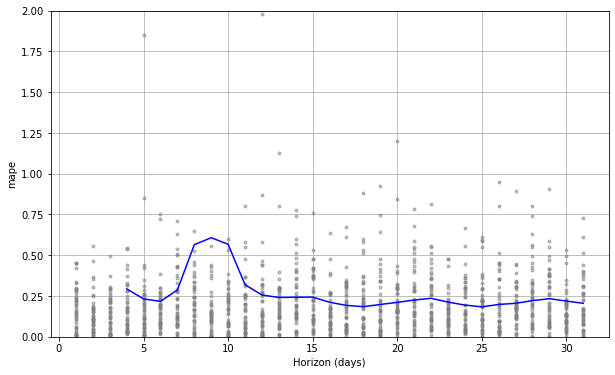

In [72]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.ylim(0,2);

## C. DEEP LEARNING: RED NEURONAL

**CONSIDERANDO UNICAMENTE LOS ACCIDENTES DE LOS 7 DIAS ANTERIORES**

Generamos el dataset con el que trabajaremos, de los que solo necesitamos fecha y frecuencia. Tenemos que asegurarnos que los valores son float.

In [73]:
red_neu_1var_df = accidents[['ds','y']]

In [74]:
red_neu_1var_df.set_index('ds', inplace = True)

In [75]:
values = red_neu_1var_df.values
values = values.astype('float32')

Como función de activación utilizamos tangente hiperbólica puesto que utilizaremos valores entre -1 y 1

In [76]:
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1)
scaled = scaler.fit_transform(values)

Escribimos la siguiente función para pasar el problema a supervisado : entrenaremos el dataset con backpropagation, entendiendo la ponderación en el reparto del error para cada una de las neuronas de la red

In [77]:
# convertimos la serie a supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Consideramos que la red neuronal va a tener 7 neuronas, debido a la estacionalidad semanal que sabemos muestran los datos

In [78]:
#nº vectores
PASOS = 7

In [79]:
# dataframe como supervisado
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.445378,-0.226891,-0.394958,-0.176471,-0.260504,-0.361345,-0.361345,0.142857
8,-0.226891,-0.394958,-0.176471,-0.260504,-0.361345,-0.361345,0.142857,0.260504
9,-0.394958,-0.176471,-0.260504,-0.361345,-0.361345,0.142857,0.260504,-0.109244
10,-0.176471,-0.260504,-0.361345,-0.361345,0.142857,0.260504,-0.109244,0.394958
11,-0.260504,-0.361345,-0.361345,0.142857,0.260504,-0.109244,0.394958,-0.042017


Preparamos los datos entre df_train y df_test, donde el test será de los últimos 31 días; y a su vez, usaremos como entradas las columnas encabezadas como var1(t-7) a (t-1) y nuestra salida el var1(t).  

In [80]:
# separamos el dataframe entre train y test, para el ultimo mes
values = reframed.values
n_train_days = 1096 - (31+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]

In [81]:
# separamos inputs de outputs, tanto de train como de test
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]

In [82]:
# reajustamos train y test [nºobservaciones, variables, pasos]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)


(1058, 1, 7) (1058,) (31, 1, 7) (31,)


Utilizaremos como optimizador Adam y métrica de pérdida el Mean Absolute Error

In [83]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

Vemos que el modelo va aprendiendo porque va bajando con los EPOCHS.

In [84]:
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

2022-06-16 23:00:02.582804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-16 23:00:02.585806: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-16 23:00:02.585895: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kschool-vm): /proc/driver/nvidia/version does not exist
2022-06-16 23:00:02.587047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 7)              56        
                                                                 
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
152/152 [==============================] - 1s 3ms/step - loss: 0.2495 - mse: 0.1005 - val_loss: 0.2985 - val_mse: 0.1207
Epoch 2/40
152/152 [==============================] - 0s 2ms/step - loss: 0.1886 - mse: 0.0586 - val_loss: 0.2428 - val_mse: 0.0831
Epoch 3/40
152/152 [==============================] - 0s 2ms

Representamos graficamente las predicciones y los datos reales de los ultimos 31 dias.

1/1 [==============================] - 0s 100ms/step
31


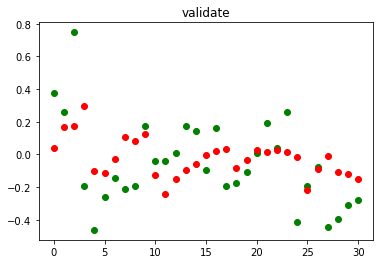

In [85]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

Vemos que el LOSS tanto en el conjunto de train como el de Validate van DC, esto indica que el modelo está aprendiendo y a su vez pareciera no haber overfitting, pues las curvas de train y validate son distintas.

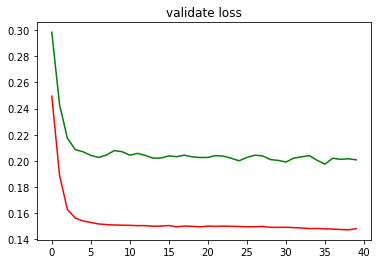

In [86]:
plt.plot(history.history['loss'],c='r')
plt.title('loss')
plt.plot(history.history['val_loss'], c='g')
plt.title('validate loss')
plt.show()

Para calcular el Acuracy utilizaremos Mean Squared Error.

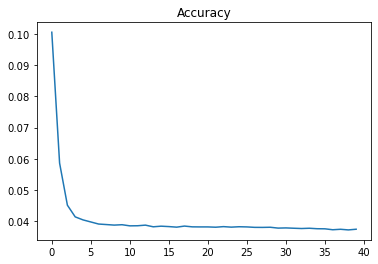

In [87]:
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

In [88]:
rmse(test_graf, predictions)

array([17.14916762, 18.5277278 , 22.47101184, 16.3256234 , 15.86005949,
       16.64062739, 17.28903432, 17.464337  , 18.84379996, 22.93978473,
       16.15282645, 15.76877987, 16.82197174, 17.54454354, 17.67488511,
       19.09444458, 23.26390073, 16.26571837, 15.72473979, 16.9873017 ,
       17.74710437, 17.88299821, 19.3495304 , 23.59125369, 16.38963351,
       15.69293636, 17.16233568, 17.95817687, 18.09943072, 19.61118424,
       23.92223092])

In [89]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head()

,real,prediccion,diferencia
0,83.0,62.991219,20.008781
1,76.0,70.514778,5.485222
2,105.0,70.840065,34.159935
3,49.0,78.025291,-29.025291
4,33.0,54.313431,-21.313431


Vamos a comparar los datos 

In [90]:
compara2.describe()

,real,prediccion,diferencia
count,31.000000,31.000000,31.000000
mean,57.290321,59.283527,-1.993192
std,15.925228,7.046191,14.772507
min,33.000000,45.914368,-29.025291
25%,48.500000,54.256269,-12.460281
50%,55.000000,59.438934,-1.282471
75%,69.500000,62.446329,8.918306
max,105.000000,78.025291,34.159935


<AxesSubplot:>

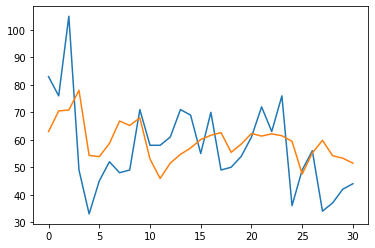

In [91]:
compara2['real'].plot()
compara2['prediccion'].plot()

Evaluación del modelo:

In [92]:
mean_squared_error(compara2['real'], compara2['prediccion'])

215.16017

In [93]:
rmse(compara2['real'], compara2['prediccion'])

14.668339

In [94]:
mean_absolute_error(compara2['real'], compara2['prediccion'])

11.943306

In [95]:
mean_absolute_percentage_error(compara2['real'], compara2['prediccion'])

0.23337099

**CONSIDERANDO LAS VARIABLES ACCIDENTES DE LOS 7 DIAS ANTERIORES, MES Y DÍA DE LA SEMANA**

In [96]:
red_neu_3var_df = accidents[['ds','y','mes','dia_sem_code']]

In [97]:
red_neu_3var_df.set_index('ds', inplace = True)

In [98]:
values = red_neu_3var_df['y'].values
values = values.astype('float32')

In [99]:
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1)
scaled = scaler.fit_transform(values)

In [100]:
red_neu_3var_df['scaled'] = scaled
scaledMerge=red_neu_3var_df.drop('y',axis=1)

In [101]:
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
ds,,,,,,,,,,,,,,,,,,,,,
2019-01-08,1.0,2.0,-0.445378,1.0,3.0,-0.226891,1.0,4.0,-0.394958,1.0,...,-0.260504,1.0,7.0,-0.361345,1.0,1.0,-0.361345,1,2,0.142857
2019-01-09,1.0,3.0,-0.226891,1.0,4.0,-0.394958,1.0,5.0,-0.176471,1.0,...,-0.361345,1.0,1.0,-0.361345,1.0,2.0,0.142857,1,3,0.260504
2019-01-10,1.0,4.0,-0.394958,1.0,5.0,-0.176471,1.0,6.0,-0.260504,1.0,...,-0.361345,1.0,2.0,0.142857,1.0,3.0,0.260504,1,4,-0.109244
2019-01-11,1.0,5.0,-0.176471,1.0,6.0,-0.260504,1.0,7.0,-0.361345,1.0,...,0.142857,1.0,3.0,0.260504,1.0,4.0,-0.109244,1,5,0.394958
2019-01-12,1.0,6.0,-0.260504,1.0,7.0,-0.361345,1.0,1.0,-0.361345,1.0,...,0.260504,1.0,4.0,-0.109244,1.0,5.0,0.394958,1,6,-0.042017


In [102]:
newReframed=reframed.drop(['var1(t)','var2(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(1089, 22)


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
ds,,,,,,,,,,,,,,,,,,,,,
2019-01-08,1.0,2.0,-0.445378,1.0,3.0,-0.226891,1.0,4.0,-0.394958,1.0,...,1.0,6.0,-0.260504,1.0,7.0,-0.361345,1.0,1.0,-0.361345,0.142857
2019-01-09,1.0,3.0,-0.226891,1.0,4.0,-0.394958,1.0,5.0,-0.176471,1.0,...,1.0,7.0,-0.361345,1.0,1.0,-0.361345,1.0,2.0,0.142857,0.260504
2019-01-10,1.0,4.0,-0.394958,1.0,5.0,-0.176471,1.0,6.0,-0.260504,1.0,...,1.0,1.0,-0.361345,1.0,2.0,0.142857,1.0,3.0,0.260504,-0.109244
2019-01-11,1.0,5.0,-0.176471,1.0,6.0,-0.260504,1.0,7.0,-0.361345,1.0,...,1.0,2.0,0.142857,1.0,3.0,0.260504,1.0,4.0,-0.109244,0.394958
2019-01-12,1.0,6.0,-0.260504,1.0,7.0,-0.361345,1.0,1.0,-0.361345,1.0,...,1.0,3.0,0.260504,1.0,4.0,-0.109244,1.0,5.0,0.394958,-0.042017


In [103]:
# split into train and test sets
values = newReframed.values
n_train_days = 1096 - (31+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]

In [104]:
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]

In [105]:
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(1058, 1, 21) (1058,) (31, 1, 21) (31,)


In [106]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [107]:
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1, 7)              154       
                                                                 
 flatten_1 (Flatten)         (None, 7)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
152/152 [==============================] - 1s 4ms/step - loss: 0.3768 - mse: 0.2177 - val_loss: 0.2366 - val_mse: 0.0844
Epoch 2/40
152/152 [==============================] - 0s 3ms/step - loss: 0.2639 - mse: 0.1053 - val_loss: 0.2035 - val_mse: 0.0701
Epoch 3/40
152/152 [==============================] - 0s

1/1 [==============================] - 0s 81ms/step
31


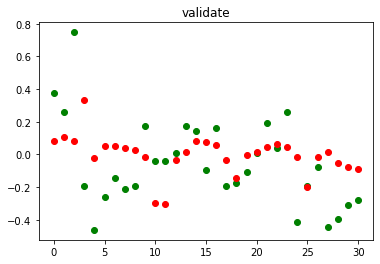

In [108]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

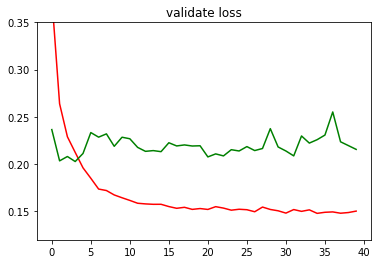

In [109]:
plt.ylim(0.12, 0.35)
plt.plot(history.history['loss'],c='r')
plt.title('loss')
plt.plot(history.history['val_loss'],c='g')
plt.title('validate loss')
plt.show()

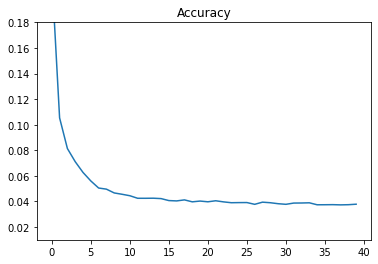

In [110]:
plt.ylim(0.01, 0.18)
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

In [111]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,82.999998,65.478585,17.521413
1,75.999999,66.686524,9.313474
2,105.000003,65.279670,39.720332
3,49.000002,80.453984,-31.453983
4,33.000000,59.029211,-26.029211
5,44.999999,63.421049,-18.421051
6,52.000001,63.469605,-11.469604
7,48.000002,62.665228,-14.665226
8,49.000002,61.930936,-12.930935
9,70.999999,59.393290,11.606709


In [112]:
compara2.describe()

,real,prediccion,diferencia
count,31.000000,31.000000,31.000000
mean,57.290323,60.245358,-2.955035
std,15.925228,7.100883,15.833732
min,33.000000,42.370590,-31.453983
25%,48.500002,58.563245,-13.468019
50%,55.000001,61.377132,-1.987170
75%,69.499999,63.669035,9.145400
max,105.000003,80.453984,39.720332


<AxesSubplot:>

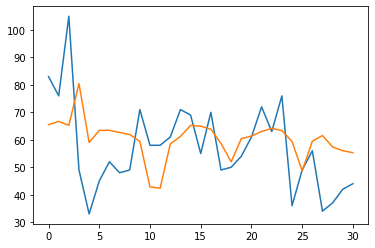

In [113]:
compara2['real'].plot()
compara2['prediccion'].plot()

Evaluación del modelo:

In [114]:
mean_squared_error(compara2['real'], compara2['prediccion'])

251.3519669469605

In [115]:
rmse(compara2['real'], compara2['prediccion'])

15.85408360476759

In [116]:
mean_absolute_error(compara2['real'], compara2['prediccion'])

12.830147388600706

In [117]:
mean_absolute_percentage_error(compara2['real'], compara2['prediccion'])

0.2542013975560584

**CONSIDERANDO LAS VARIABLES ACCIDENTES DE LOS 7 DIAS ANTERIORES Y EMBEDDINGS MES Y DÍA DE LA SEMANA**

In [118]:
red_neu_3var_df = accidents[['ds','y','mes','dia_sem_code']]

In [119]:
red_neu_3var_df.set_index('ds', inplace = True)

In [120]:
red_neu_emb_df = accidents[['ds','y']]

In [121]:
red_neu_emb_df.set_index('ds', inplace = True)

In [122]:
# load dataset
values = red_neu_emb_df['y'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) 

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=red_neu_3var_df['dia_sem_code']
reframed['month']=red_neu_3var_df['mes']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=red_neu_3var_df['dia_sem_code'][i+8]
    reframed['month'].loc[contador]=red_neu_3var_df['mes'][i+8]
    contador=contador+1
reframed.shape

(1089, 10)

In [123]:
reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)',\
                      'var1(t-2)','var1(t-1)','var1(t)'] ]
reordenado.dropna(inplace=True)
reordenado.head()

,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,3.0,1.0,-0.445378,-0.226891,-0.394958,-0.176471,-0.260504,-0.361345,-0.361345,0.142857
1,4.0,1.0,-0.226891,-0.394958,-0.176471,-0.260504,-0.361345,-0.361345,0.142857,0.260504
2,5.0,1.0,-0.394958,-0.176471,-0.260504,-0.361345,-0.361345,0.142857,0.260504,-0.109244
3,6.0,1.0,-0.176471,-0.260504,-0.361345,-0.361345,0.142857,0.260504,-0.109244,0.394958
4,7.0,1.0,-0.260504,-0.361345,-0.361345,0.142857,0.260504,-0.109244,0.394958,-0.042017


In [124]:
training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
#training_data.head()
valid_data = training_data[1086-31:1086]
valid_target=target_data[1086-31:1086]

training_data = training_data[0:1086]
target_data=target_data[0:1086]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

(1086, 9) (1086,) (31, 9) (31,)


In [125]:
def crear_modeloEmbeddings():
    emb_dias = 2 #tamanio profundidad de embeddings
    emb_meses = 4
    

    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)
    
    
    in_cli = Input(shape=[PASOS], name = 'cli')

    fe = concatenate([(emb_dias), (emb_meses)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses,in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model

In [126]:
EPOCHS=40

model = crear_modeloEmbeddings()

continuas=training_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuas=valid_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['weekday'],training_data['month'],continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['weekday'],valid_data['month'],valid_continuas],valid_target))



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dias (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 meses (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 2)         16          ['dias[0][0]']                   
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 4)         52          ['meses[0][0]']                  
                                                                                              

1/1 [==============================] - 0s 60ms/step
31


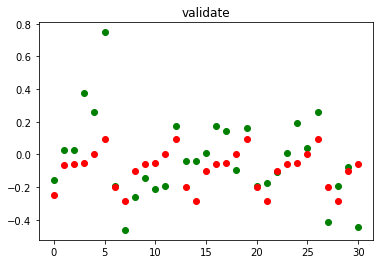

In [127]:
results=model.predict([valid_data['weekday'],valid_data['month'],valid_continuas])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

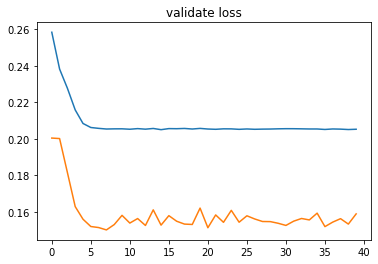

In [128]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

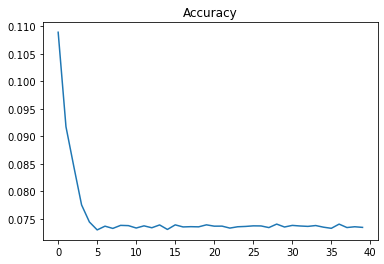

In [129]:
plt.title('Accuracy')
plt.plot(history.history['MSE'])
plt.show()

In [130]:
compara = pd.DataFrame(np.array([valid_target, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(12)

,real,prediccion,diferencia
0,51.0,45.552975,5.447025
1,62.0,56.638912,5.361088
2,62.0,56.918957,5.081043
3,83.0,57.400219,25.599781
4,76.0,60.480797,15.519203
5,105.0,66.260422,38.739578
6,49.0,48.647427,0.352573
7,33.0,43.392284,-10.392284
8,45.0,54.301258,-9.301258
9,52.0,56.918957,-4.918957


<AxesSubplot:>

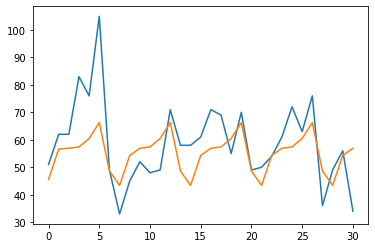

In [131]:
compara2['real'].plot()
compara2['prediccion'].plot()

Evaluación del modelo:

In [132]:
mean_squared_error(compara2['real'], compara2['prediccion'])

153.5384

In [133]:
rmse(compara2['real'], compara2['prediccion'])

12.391062

In [134]:
mean_absolute_error(compara2['real'], compara2['prediccion'])

9.450567

In [135]:
mean_absolute_percentage_error(compara2['real'], compara2['prediccion'])

0.16362791

De los tres modelos de redes neuronales aplicados consideramos que el que mejores predicciones podrá generar será el que CONSIDERA LAS VARIABLES ACCIDENTES DE LOS 7 DIAS ANTERIORES Y EMBEDDINGS MES Y DÍA DE LA SEMANA  ya que es el que mejores medidas de medición tiene.

## PREDICCIÓN

In [136]:
ultimosDias = red_neu_3var_df['2021-12-16':'2021-12-31']
ultimosDias

,y,mes,dia_sem_code
ds,,,
2021-12-16,55,12,4
2021-12-17,70,12,5
2021-12-18,49,12,6
2021-12-19,50,12,7
2021-12-20,54,12,1
2021-12-21,61,12,2
2021-12-22,72,12,3
2021-12-23,63,12,4
2021-12-24,76,12,5


In [137]:
# load dataset
values = ultimosDias['y'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=ultimosDias['dia_sem_code']
reframed['month']=ultimosDias['mes']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=ultimosDias['dia_sem_code'][i+8]
    reframed['month'].loc[contador]=ultimosDias['mes'][i+8]
    contador=contador+1
reframed.head()

reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)'] ]
reordenado.dropna(inplace=True)
reordenado

,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
0,5.0,12.0,0.000000,0.714286,-0.285714,-0.238095,-0.047619,0.285714,0.809524
1,6.0,12.0,0.714286,-0.285714,-0.238095,-0.047619,0.285714,0.809524,0.380952
2,7.0,12.0,-0.285714,-0.238095,-0.047619,0.285714,0.809524,0.380952,1.000000
3,1.0,12.0,-0.238095,-0.047619,0.285714,0.809524,0.380952,1.000000,-0.904762
4,2.0,12.0,-0.047619,0.285714,0.809524,0.380952,1.000000,-0.904762,-0.285714
5,3.0,12.0,0.285714,0.809524,0.380952,1.000000,-0.904762,-0.285714,0.047619
6,4.0,12.0,0.809524,0.380952,1.000000,-0.904762,-0.285714,0.047619,-1.000000
7,5.0,12.0,0.380952,1.000000,-0.904762,-0.285714,0.047619,-1.000000,-0.857143


In [138]:
values = reordenado.values
x_test = values[5:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = reordenado.weekday[len(reordenado.index)-1]
ultDiaSemana

(3, 1, 9)
[[[ 3.         12.          0.28571439  0.80952382  0.38095236
    1.         -0.90476191 -0.28571415  0.0476191 ]]

 [[ 4.         12.          0.80952382  0.38095236  1.
   -0.90476191 -0.28571415  0.0476191  -1.        ]]

 [[ 5.         12.          0.38095236  1.         -0.90476191
   -0.28571415  0.0476191  -1.         -0.85714281]]]


5.0

In [139]:
model = crear_modeloEmbeddings()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dias (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 meses (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 2)         16          ['dias[0][0]']                   
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 4)         52          ['meses[0][0]']                  
                                                                                            

In [140]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i+2] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][0]=ultDiaSemana
    x_test[0][0][1]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

In [141]:
results=[]
for i in range(7):
    dia=np.array([x_test[0][0][0]])
    mes=np.array([x_test[0][0][1]])
    valores=np.array([x_test[0][0][2:9]])
    parcial=model.predict([dia, mes, valores])
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

1/1 [==============================] - 0s 86ms/step
pred 0 [[[ 3.         12.          0.28571439  0.80952382  0.38095236
    1.         -0.90476191 -0.28571415  0.0476191 ]]

 [[ 4.         12.          0.80952382  0.38095236  1.
   -0.90476191 -0.28571415  0.0476191  -1.        ]]

 [[ 5.         12.          0.38095236  1.         -0.90476191
   -0.28571415  0.0476191  -1.         -0.85714281]]]
1/1 [==============================] - 0s 29ms/step
pred 1 [[[ 6.         12.          0.80952382  0.38095236  1.
   -0.90476191 -0.28571415  0.0476191   0.05589855]]

 [[ 4.         12.          0.80952382  0.38095236  1.
   -0.90476191 -0.28571415  0.0476191  -1.        ]]

 [[ 5.         12.          0.38095236  1.         -0.90476191
   -0.28571415  0.0476191  -1.         -0.85714281]]]
1/1 [==============================] - 0s 26ms/step
pred 2 [[[ 0.         12.          0.38095236  1.         -0.90476191
   -0.28571415  0.0476191   0.05589855  0.01614622]]

 [[ 4.         12.          

In [142]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([0.05589855], dtype=float32), array([0.01614622], dtype=float32), array([0.0210521], dtype=float32), array([0.02845021], dtype=float32), array([0.06263356], dtype=float32), array([0.05589855], dtype=float32), array([0.05623456], dtype=float32)]


array([[56.17386892],
       [55.33907003],
       [55.44209362],
       [55.59745392],
       [56.31530417],
       [56.17386892],
       [56.18092513]])

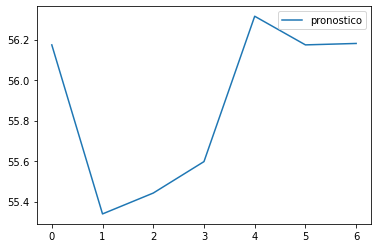

In [143]:
prediccion1SemanaEnero = pd.DataFrame(inverted)
prediccion1SemanaEnero.columns = ['pronostico']
prediccion1SemanaEnero.plot()
prediccion1SemanaEnero.to_csv(r'/home/dsc/Master DS/TFM/GIT/DATOS_PROCESADOS/pronostico_embeddings.csv')